# Hidden markov model (HMM)

The goal is to use to find looped and unlooped states in the data generated by Pavel's model.

We will use Gaussian model for emission. 
Given all the data we fit the all the parameters (gaussian parameters, transition probability between looped/unlooped).

Once we have the model, we use the model to predict the states.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from hmmlearn import hmm
from matplotlib.backends.backend_pdf import PdfPages
from utils import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import glob
import matplotlib
import matplotlib.colors as mcolors
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
reproducible = True
distance_conversion = (0.012*np.sqrt(40)) # 1 a.u. = 0.08 um
rolling = 1
if reproducible:
    np.random.seed(42)
subsample = False

if subsample:
    number_subsample = 200000


# Reading simulated data

In [4]:
dataset_name = "langevin_release_17500-1kbpersec-on-off-naked_220119"
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/langevin_release_17500-1kbpersec-on-off-naked_finer_scale_5x5_different_definition_gt_220113/langevin_convergent_on_off/"
# dataset_name = "langevin_release_175000-0.1kbpersec-on-off-naked_220119"
# basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/langevin_release_175000-0.1kbpersec-on-off-naked_finer_scale_5x5_different_definition_gt_220113/langevin_convergent_on_off/"
list_files = glob.glob(f"{basedir}/*/*/*/*/*/*dat")

df = pd.DataFrame(list_files, columns=["filename"])
df[["ctcf", "speed", "loading", "unloading", "rep"]] = df["filename"].str.extract(
    r"langevin_convergent_on_off\/([\w+]*)\/([\d+]*)\/([\d]\.[\d+]*)\/([\d]\.[\d+]*)\/([\d+]*)\/",
    expand=True,
)
df["condition"] = df["speed"] + "." + df["loading"] + "_" + df["unloading"]
df["uniqueid"] = (
    "ctcf"
    + df["ctcf"]
    + "."
    + "rad21"
    + "on"
    + "_"
    + df["speed"]
    + "."
    + df["loading"]
    + "."
    + df["unloading"]
    + "."
    + df["rep"]
)

In [5]:
basedir_control = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/langevin_release_17500-1kbpersec-on-off-naked_finer_scale_5x5_different_definition_gt_220113/naked_chain/"
# basedir_control = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/langevin_release_175000-0.1kbpersec-on-off-naked_finer_scale_5x5_different_definition_gt_220113/naked_chain/"
list_files_control = glob.glob(f"{basedir_control}/*/*dat")

control = pd.DataFrame(list_files_control, columns=["filename"])

In [6]:
distances_control_original = pd.DataFrame()
for file in control.filename.unique():
    tmp = pd.read_csv(file, sep=" ")
    tmp.distance = tmp.distance * distance_conversion
    tmp['rad21'] = "off"
    tmp['frame'] = np.arange(len(tmp))
    if subsample:
        tmp = tmp.head(number_subsample)
    distances_control_original = pd.concat([distances_control_original, tmp])

In [7]:
distances_original = pd.DataFrame()
for condition, sub2 in df.groupby('condition'):
    for uniqueid, sub1 in sub2.groupby('uniqueid'):
        for ct, sub in sub1.groupby('ctcf'):
            for file in sub.filename.unique():
                tmp = pd.read_csv(file, sep=" ")
                tmp.distance = tmp.distance * distance_conversion
                tmp['condition'] = condition
                tmp['frame'] = np.arange(len(tmp))
                tmp['uniqueid'] = uniqueid 
                tmp['ctcf'] = ct
                tmp['rad21'] = "on"
                if subsample:
                    tmp = tmp.head(number_subsample)
                distances_original = pd.concat([distances_original, tmp])

# GT 
# distances_original.bond[distances_original.bond > 1] = 1
# distances_original.bond = 1 - distances_original.bond.values

# Subsampling  to 30s and training 2 state hmm

In [146]:
# choose neighbors
nneighbor = 2
idx = np.where(
    np.array([abs(eval(x)) for x in distances_original.columns[1:][:-5]])
    < 18 - nneighbor
)[0]
names_remove = distances_original.columns[idx + 1]

# subsampling and remove too far neighbors 
subsample_every = 30
distances = distances_original.iloc[::subsample_every].copy().drop(names_remove, axis=1)

# calculate the GT ctcf mediated loop
idx = (
    np.where(
        np.array([abs(eval(x)) for x in distances.columns[1:][:-5]]) >= 18 - nneighbor
    )[0]
    + 1
)
distances["bond"] = distances.iloc[:, idx].sum(axis=1)
distances.bond[distances.bond > 1] = 1
distances.bond = 1 - distances.bond.values
distances_control = (
    distances_control_original.iloc[::subsample_every].copy().drop(names_remove, axis=1)
)
distances_control["bond"] = distances_control.iloc[:, idx].sum(axis=1)
distances_control.bond[distances_control.bond > 1] = 1
distances_control.bond = 1 - distances_control.bond.values

# add experimental noise
seed = 0
np.random.seed(seed)
distances.distance = distances.distance.values + np.random.normal(
    loc=0.0, scale=0.064, size=len(distances)
)
distances.frame = distances.frame.values / subsample_every

np.random.seed(seed)
distances_control.frame = distances_control.frame.values / subsample_every
distances_control.distance = distances_control.distance.values + np.random.normal(
    loc=0.0, scale=0.064, size=len(distances_control)
)


# run HMM training on all conditions
results = {}
np.random.seed(seed)
for condition, sub in distances.groupby("condition"):
    traj2d = np.reshape(
        sub[sub.ctcf == "on"].distance.to_numpy(),
        (-1, 1),
    )
    model = hmm.GaussianHMM(
        n_components=2,
        covariance_type="full",
        min_covar=0.1,
        n_iter=10000,
        params="mtc",
        init_params="mtc",
    )

    # instead of fitting
    model.startprob_ = [0.5, 0.5]
    model.fit(traj2d)

    results[condition] = model
models2hmm = results.copy()

/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tungstenfs/scratch/ggiorget/zhan/bin/anaconda3/envs/hmmlearn/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [147]:
# reorder HMM model such that the first gaussian is always the lowest
for key, model in results.items():
    newmodel = reorder_hmm_model_parameters(model)
    model = newmodel
    means = (model.means_)
    sigmas = np.sqrt(model.covars_.squeeze())
    w = np.array(model.transmat_)
    logProb = model.score(traj2d)
    print(f"ctcf-speed-loading-unloading = {key}")
    print(f"Gaussian means: {means}")
    print(f"Gaussian std: {sigmas}")
    print(f"Transition rates: {w}")
    print("----------\n")

ctcf-speed-loading-unloading = 17500.0.02_0.002
Gaussian means: [[0.17586966]
 [0.37404523]]
Gaussian std: [0.0929732  0.13521047]
Transition rates: [[0.99318183 0.00681817]
 [0.01063641 0.98936359]]
----------

ctcf-speed-loading-unloading = 17500.0.02_0.005
Gaussian means: [[0.15797468]
 [0.4394071 ]]
Gaussian std: [0.09230262 0.15931026]
Transition rates: [[0.97880448 0.02119552]
 [0.01654571 0.98345429]]
----------

ctcf-speed-loading-unloading = 17500.0.02_0.01
Gaussian means: [[0.1478314 ]
 [0.46358342]]
Gaussian std: [0.09256352 0.16192445]
Transition rates: [[0.94742249 0.05257751]
 [0.04190779 0.95809221]]
----------

ctcf-speed-loading-unloading = 17500.0.02_0.02
Gaussian means: [[0.12680062]
 [0.4783671 ]]
Gaussian std: [0.08884687 0.16832723]
Transition rates: [[0.89272373 0.10727627]
 [0.04560871 0.95439129]]
----------

ctcf-speed-loading-unloading = 17500.0.02_0.05
Gaussian means: [[0.34032561]
 [0.61409106]]
Gaussian std: [0.15313551 0.14559608]
Transition rates: [[0.87

# Reading experimental data

In [148]:
# experiments
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines"
name = "two_colors_distance_30s"
dataset = f"{basedir}/211129_{name}.csv.zip"
list_cell_lines = ["1A2", "1B1"]
bins = np.arange(30, 10000, 150)

with open(f"{basedir}/hmmmodel_two_colors_distance_30s.obj", "rb") as f:
    exp_model = pickle.load(f)

exp = pd.read_csv(dataset)
exp = exp[exp.cell_line.isin(list_cell_lines)]
exp["condition"] = exp["cell_line"] + "_" + exp["induction_time"]

hue_order = sorted(exp["condition"].unique())
(
    exp_durations,
    exp_second_passage_times,
    exp_fraction_time,
    exp_conditions,
    exp_data_filtered,
) = calculate_duration_second_passage_time(
    data=exp,
    resolution=30,
    model=exp_model,
    fraction_nan_max=0.2,
)

# exp_duration_distributions = pd.DataFrame()
# for cond in ["1A2_0min", "1B1_0min"]:
#     hist = plt.hist(exp_durations.contact_duration[exp_durations.condition == cond], bins = bins, density = True)
#     tmp = pd.DataFrame(hist[0])
#     tmp.columns = ["contact_duration"]
#     tmp['condition'] = cond
#     exp_duration_distributions = pd.concat([exp_duration_distributions, tmp])
    
# exp_duration_distributions['ctcf'] = "on"
# exp_duration_distributions['ctcf'][exp_duration_distributions.condition == "1A2_0min"] = "off"
# exp_duration_distributions

# calculate the median contact duration and second passage time across all parameters

In [149]:
mean = pd.DataFrame()
alldata = pd.DataFrame()
sim_duration_distributions = pd.DataFrame()
for cond in distances.condition.unique():
    subsample_every = 1
    distances_selected = (
        distances[distances.condition == cond].iloc[::subsample_every].copy()
    )
    distances_selected.frame = distances_selected.frame.values / subsample_every
    distances_selected.condition = distances_selected.uniqueid
    (
        durations,
        second_passage_times,
        fraction_time,
        conditions,
        data,
    ) = calculate_duration_second_passage_time(
        distances_selected, resolution=30, model=results[cond]
    )
    tmp = pd.DataFrame(
        durations.groupby("cell_line").mean()["contact_duration"]
    ).reset_index()
    tmp["second_passage_time"] = (
        second_passage_times.groupby("cell_line").mean()["second_passage_time"].values
    )
    tmp["condition"] = cond
    mean = pd.concat([mean, tmp])
    alldata = pd.concat([data, alldata])

#     for ctcf, sub in durations.groupby("cell_line"):
#         hist = plt.hist(sub.contact_duration, bins=bins, density=True)
#         tmp = pd.DataFrame(hist[0])
#         tmp.columns = ["contact_duration"]
#         tmp["condition"] = cond
#         tmp["ctcf"] = ctcf
#         sim_duration_distributions = pd.concat([sim_duration_distributions, tmp])

# plt.close() 

# sim_duration_distributions["ctcf"] = [
#     x.replace("ctcf", "")
#     for x in sim_duration_distributions.ctcf.str.split(".", expand=True)[0]
# ]
mean[["speed", "loading", "unloading"]] = mean["condition"].str.extract(
    r"([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True
)
mean["ctcf"] = mean["cell_line"]

In [150]:
# # calculate the kl divergence
# def my_distance(p, q):
#     assert len(p) == len(q)
#     return np.sum(np.abs(p - q))


# dist_durations = []
# conditions = []
# for cond, subsub in sim_duration_distributions.groupby("condition"):
#     appo = 0
#     for ctcf, sub in subsub.groupby("ctcf"):
#         appo += my_distance(
#             sub.contact_duration,
#             exp_duration_distributions["contact_duration"][
#                 exp_duration_distributions.ctcf == ctcf
#             ],
#         )
#     dist_durations.append(appo)
#     conditions.append(cond)

# dist_durations = pd.DataFrame(dist_durations, columns=["distance_durations"])
# dist_durations["condition"] = conditions

# Extracting gaussian means of HMM model from simulated data

In [151]:
gaussian_means = pd.DataFrame()

for key, model in results.items():
    tmp = pd.DataFrame(model.means_, columns=["gaussian_means"])
    tmp["state"] = ["looped", "unlooped"]
    tmp["condition"] = key
    gaussian_means = pd.concat([gaussian_means, tmp])
gaussian_means[["speed", "loading", "unloading"]] = gaussian_means[
    "condition"
].str.extract(r"([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True)

### calculate distance of gaussian means between simulation and experiments

In [152]:
dist_gaussian_means_looped = gaussian_means[["gaussian_means", "condition"]][gaussian_means.state == "looped"]
dist_gaussian_means_unlooped = gaussian_means[["gaussian_means", "condition"]][gaussian_means.state == "unlooped"]
dist_gaussian_means_looped["gaussian_means"] = np.abs(dist_gaussian_means_looped["gaussian_means"].values - 0.1493922) / 0.1493922
dist_gaussian_means_unlooped["gaussian_means"] = np.abs(dist_gaussian_means_unlooped["gaussian_means"].values - 0.28807371) / 0.28807371

dist_gaussian_means = pd.merge(dist_gaussian_means_looped, dist_gaussian_means_unlooped, on="condition")
# since we want to keep only the looped state, I could have done this more easily
dist_gaussian_means["dist_gaussian_means"] = dist_gaussian_means.gaussian_means_x # + dist_gaussian_means.gaussian_means_y

# Plot Gaussian mean as heatmap

posx and posy should be finite values
posx and posy should be finite values


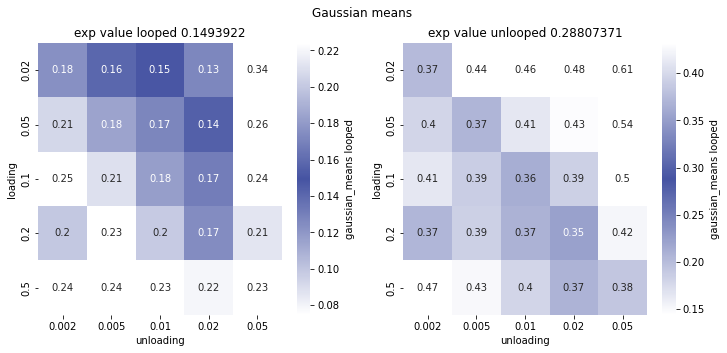

In [313]:
pdf = PdfPages(f"/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/{dataset_name}_2states_HMM_neighbor_{nneighbor}.pdf")

exp_looped = 0.1493922
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(1, 1, 1),(69/255, 83/255, 162/255),(1, 1, 1)])
norm = mcolors.TwoSlopeNorm(vmin=exp_looped*0.5, vcenter=exp_looped, vmax=exp_looped*1.5)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    gaussian_means[gaussian_means.state=="looped"].pivot("loading", "unloading", "gaussian_means"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "gaussian_means looped"},
    norm = norm, 
    ax = ax[0]
)
ax[0].set_title(f"exp value looped {exp_looped}")

exp_unlooped = 0.28807371
norm = mcolors.TwoSlopeNorm(vmin=exp_unlooped*0.5, vcenter=exp_unlooped, vmax=exp_unlooped*1.5)
sns.heatmap(
    gaussian_means[gaussian_means.state=="unlooped"].pivot("loading", "unloading", "gaussian_means"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "gaussian_means looped"},
    norm = norm, 
    ax = ax[1]
)
ax[1].set_title(f"exp value unlooped {exp_unlooped}")
plt.suptitle("Gaussian means")
plt.show()
pdf.savefig(fig)


# Plot average first passage time

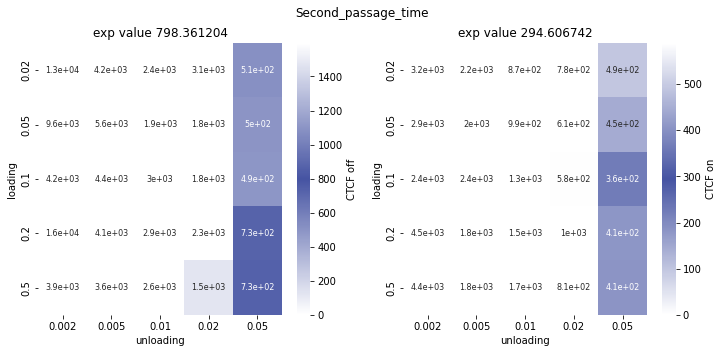

In [314]:
# ctcf_off = 420
ctcf_off = 798.361204
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off*0, vcenter=ctcf_off, vmax=ctcf_off*2)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    mean[mean.ctcf=="ctcfoff.rad21on"].pivot("loading", "unloading", "second_passage_time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
)
ax[0].set_title(f"exp value {ctcf_off}")

# ctcf_on = 150
ctcf_on = 294.606742
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on*0, vcenter=ctcf_on, vmax=ctcf_on*2)
sns.heatmap(
    mean[mean.ctcf=="ctcfon.rad21on"].pivot("loading", "unloading", "second_passage_time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
)
ax[1].set_title(f"exp value {ctcf_on}")
plt.suptitle("Second_passage_time")
plt.show()
pdf.savefig(fig)

# Plot average contact duration

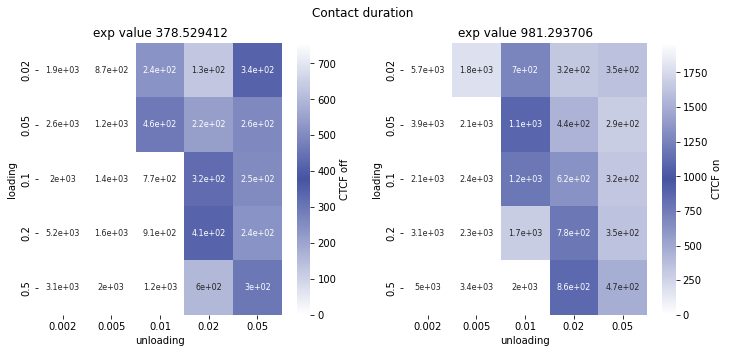

In [315]:
# ctcf_off = 270
ctcf_off = 378.529412
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off*0, vcenter=ctcf_off, vmax=ctcf_off*2)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    mean[mean.ctcf=="ctcfoff.rad21on"].pivot("loading", "unloading", "contact_duration"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
)
ax[0].set_title(f"exp value {ctcf_off}")

# ctcf_on = 480
ctcf_on = 981.293706
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on*0, vcenter=ctcf_on, vmax=ctcf_on*2)
sns.heatmap(
    mean[mean.ctcf=="ctcfon.rad21on"].pivot("loading", "unloading", "contact_duration"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
)
ax[1].set_title(f"exp value {ctcf_on}")
plt.suptitle("Contact duration")
plt.show()
pdf.savefig(fig)

### calculate distance between contact duration between simulation and experiments

In [316]:
dist_contact_duration = []
conditions = []

for cond, sub in mean.groupby("condition"):
    conditions.append(cond)
    appo = np.abs(sub.contact_duration[sub.cell_line == "ctcfoff.rad21on"].values - ctcf_off)/ctcf_off
    appo = appo + np.abs(sub.contact_duration[sub.cell_line == "ctcfon.rad21on"].values - ctcf_on)/ctcf_on
    dist_contact_duration.append(appo)

dist_contact_duration = pd.DataFrame(dist_contact_duration, columns = ["dist_contact_duration"])
dist_contact_duration["condition"] = conditions

# HMM fraction of time spend in each looped across all parameters

posx and posy should be finite values
posx and posy should be finite values


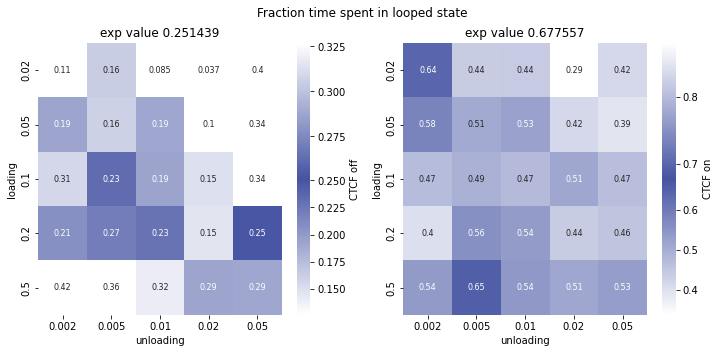

In [317]:
conditions = np.unique(
    [
        x[:-2].replace("ctcfon.", "").replace("ctcfoff.", "")
        for x in alldata.condition.unique()
    ]
)
# time_spent = pd.DataFrame([0.677557,
#         0.251439,])
# time_spent["ctcf"] = ["on", "off"]
# time_spent["type"] = "exp"
time_spent = pd.DataFrame()

for cond in conditions:
    subset_on = alldata[
        ["ctcfon." + cond in x for x in alldata.condition]
    ].copy()
    subset_off = alldata[
        ["ctcfoff." + cond in x for x in alldata.condition]
    ].copy()
    
    time = pd.DataFrame(
    [
        1 - subset_on.prediction.mean(),
        1 - subset_off.prediction.mean(),
    ],
    columns=["time"],
    )

    time["ctcf"] = ["on", "off"]
    time["type"] = cond
    time_spent = pd.concat([time_spent, time])

time_spent[["speed", "loading", "unloading"]] = time_spent["type"].str.extract(
    r"([\d+]*)\.([\d]\.[\d+]*)\.([\d]\.[\d+]*)", expand=True
)

ctcf_off = 0.251439
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off*0.5, vcenter=ctcf_off, vmax=ctcf_off*1.3)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    time_spent[time_spent.ctcf=="off"].pivot("loading", "unloading", "time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
)
ax[0].set_title(f"exp value {ctcf_off}")

ctcf_on = 0.677557
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on*0.5, vcenter=ctcf_on, vmax=ctcf_on*1.3)
sns.heatmap(
    time_spent[time_spent.ctcf=="on"].pivot("loading", "unloading", "time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
)
ax[1].set_title(f"exp value {ctcf_on}")
plt.suptitle("Fraction time spent in looped state")
plt.show()
pdf.savefig(fig)

# effect of CTCF in time spent in the looped state across all parameters

posx and posy should be finite values
posx and posy should be finite values


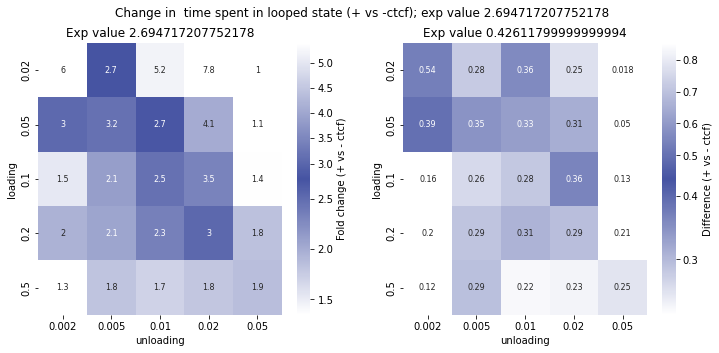

In [318]:
ctcfon = time_spent[time_spent.ctcf=="on"].copy()
ctcfoff = time_spent[time_spent.ctcf=="off"].copy()

ctcf = pd.merge(ctcfon, ctcfoff, on = ["loading", "unloading", "speed"])
ctcf["enrichment"] = ctcf["time_x"] / ctcf["time_y"]
ctcf["difference"] =  ctcf["time_x"] - ctcf["time_y"]

enrichment =  0.677557/ 0.251439
norm = mcolors.TwoSlopeNorm(vmin=enrichment*0.5, vcenter=enrichment, vmax=enrichment*2)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    ctcf.pivot("loading", "unloading", "enrichment"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "Fold change (+ vs - ctcf)"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
   
)

ax[0].set_title(f"Exp value {enrichment}")

difference = 0.677557- 0.251439
norm = mcolors.TwoSlopeNorm(vmin=difference*0.5, vcenter=difference, vmax=difference*2)
sns.heatmap(
    ctcf.pivot("loading", "unloading", "difference"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "Difference (+ vs - ctcf)"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
   
)

ax[1].set_title(f"Exp value {difference}")



plt.suptitle(f"Change in  time spent in looped state (+ vs -ctcf); exp value {enrichment}")
plt.show()
pdf.savefig(fig)

# Find the best case

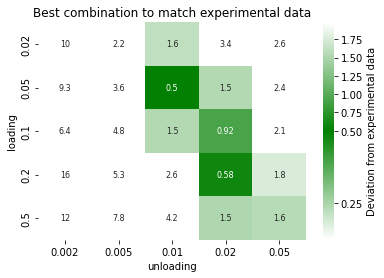

In [319]:
# def standardize(x):
#     return (x - np.mean(x)) / np.std(x)


#     return( (x) / (np.max(x) - np.min(x)))

dist_ctcf_enrichment = ctcf.copy()
dist_ctcf_enrichment["dist_ctcf_enrichment"] = np.abs(
    dist_ctcf_enrichment.enrichment - (0.677557 / 0.251439)
) / (0.677557 / 0.251439)

dist_gaussian_means[
    "newcondition"
] = "rad21on_" + dist_gaussian_means.condition.str.replace("_", ".")
dist_contact_duration[
    "newcondition"
] = "rad21on_" + dist_contact_duration.condition.str.replace("_", ".")

dist_together = pd.merge(
    dist_gaussian_means, dist_ctcf_enrichment, left_on="newcondition", right_on="type_x"
)
dist_together = pd.merge(dist_together, dist_contact_duration, on="newcondition")
# dist_together.distance_durations = standardize(dist_together.distance_durations.values)
# dist_together.dist_fraction_time = standardize(dist_together.dist_fraction_time.values)
dist_together["dist"] = (
    dist_together.dist_gaussian_means
    + dist_together.dist_ctcf_enrichment
    + dist_together.dist_contact_duration
)

dist_together[["speed", "loading", "unloading"]] = dist_together[
    "condition_x"
].str.extract(r"([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True)

minimum = dist_together.dist.min()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","green","white"])
norm = mcolors.TwoSlopeNorm(vmin=minimum * 0.25, vcenter=minimum, vmax=minimum * 4)
ax = sns.heatmap(
    dist_together.pivot("loading", "unloading", "dist"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "Deviation from experimental data"},
    norm=norm,
    annot_kws={"size": 8},
)
plt.title("Best combination to match experimental data")
pdf.savefig(ax.figure)

In [320]:
top = 5 #number of best matches
dist_together["realistic"] = (
    dist_together["speed"]
    + "."
    + dist_together["loading"]
    + "."
    + dist_together["unloading"]
)

realistic_list = dist_together.sort_values('dist').head(top).realistic.values
realistic_model_list = dist_together.sort_values('dist').head(top).condition_x.values

realistic_best = realistic_list[0]
realistic_model_best = realistic_model_list[0]

# fraction of time spent in each state in the best case

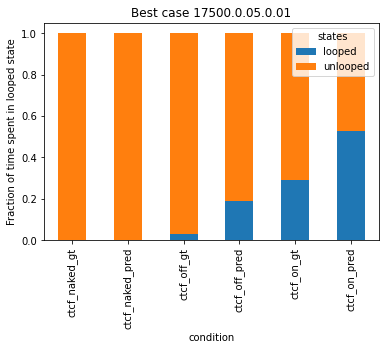

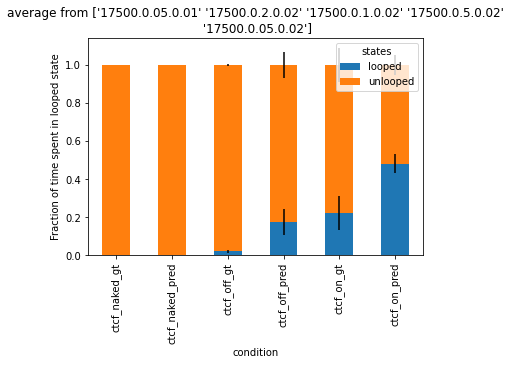

In [321]:
traj = distances_control.distance.values.reshape(-1, 1)
time_average = pd.DataFrame()
for realistic_select, realistic_model_select in zip(
    realistic_list, realistic_model_list
):
    m = results[realistic_model_select]
    distances_control["prediction"] = m.predict(traj)

    subset_on = alldata[
        ["ctcfon.rad21on_" + realistic_select in x for x in alldata.condition]
    ].copy()
    subset_off = alldata[
        ["ctcfoff.rad21on_" + realistic_select in x for x in alldata.condition]
    ].copy()
    
    time = pd.DataFrame(
        [
            1 - subset_on.prediction.mean(),
            1 - subset_on.bond.mean(),
            1 - subset_off.prediction.mean(),
            1 - subset_off.bond.mean(),
            1 - distances_control.prediction.mean(),
            1 - distances_control.bond.mean(),
            subset_on.prediction.mean(),
            subset_on.bond.mean(),
            subset_off.prediction.mean(),
            subset_off.bond.mean(),
            distances_control.prediction.mean(),
            distances_control.bond.mean(),
        ],
        columns=["time"],
    )

    time["ctcf"] = [
        "on",
        "on",
        "off",
        "off",
        "naked",
        "naked",
        "on",
        "on",
        "off",
        "off",
        "naked",
        "naked",
    ]
    time["type"] = [
        "pred",
        "gt",
        "pred",
        "gt",
        "pred",
        "gt",
        "pred",
        "gt",
        "pred",
        "gt",
        "pred",
        "gt",
    ]
    time["condition"] = "ctcf_" + time["ctcf"] + "_" + time["type"]
    time["states"] = [
        "looped",
        "looped",
        "looped",
        "looped",
        "looped",
        "looped",
        "unlooped",
        "unlooped",
        "unlooped",
        "unlooped",
        "unlooped",
        "unlooped",
    ]
    time['index'] = np.arange(0, len(time))
    if realistic_select == realistic_best:
        fig = time.pivot(index='states', columns='condition', values='time').T.plot(kind="bar", stacked=True)
        plt.ylabel("Fraction of time spent in looped state")
        plt.title(f"Best case {realistic_best}")
        pdf.savefig(fig.figure, bbox_inches='tight')
    time_average = pd.concat([time, time_average])
    
std = time_average.groupby(list(time_average.columns[1:])).std().reset_index()
av = time_average.groupby(list(time_average.columns[1:])).mean().reset_index()
av_std = pd.merge(std, av, on=list(time_average.columns[1:]))
av_std.columns = ['ctcf', 'type', 'condition', 'states', 'index', 'std', 'mean']

means = av_std.pivot(index='states', columns='condition', values='mean').T
errors = av_std.pivot(index='states', columns='condition', values='std').T
fig = means.plot(kind="bar", yerr=errors, stacked=True)

plt.ylabel("Fraction of time spent in looped state")
plt.title(f"average from {realistic_list}")
pdf.savefig(fig.figure, bbox_inches='tight')

# fraction of time in looped state in exp and best case of simulation

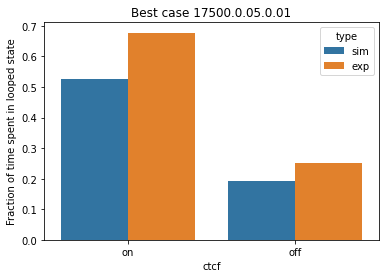

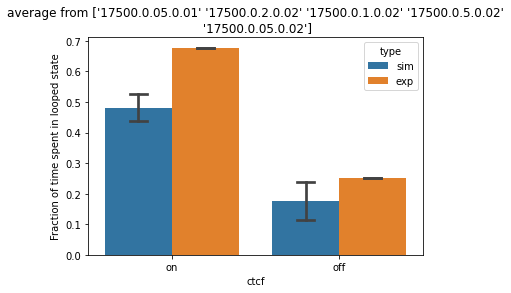

In [322]:
time_average = pd.DataFrame()
for realistic_select in realistic_list:

    subset_on = alldata[
        ["ctcfon.rad21on_" + realistic_select in x for x in alldata.condition]
    ].copy()
    subset_off = alldata[
        ["ctcfoff.rad21on_" + realistic_select in x for x in alldata.condition]
    ].copy()
    time = pd.DataFrame(
        [
            1 - subset_on.prediction.mean(),
            1 - subset_off.prediction.mean(),
            0.677557,
            0.251439,
        ],
        columns=["time"],
    )

    time["ctcf"] = ["on", "off", "on", "off"]
    time["type"] = ["sim", "sim", "exp", "exp"]
    time["index"] = np.arange(0,len(time))
    if realistic_select == realistic_best:
        ax = sns.barplot(data=time, hue="type", x="ctcf", y="time")
        plt.ylabel("Fraction of time spent in looped state")
        plt.title(f"Best case {realistic_best}")
        pdf.savefig(ax.figure)
    time_average = pd.concat([time, time_average])
    
plt.figure()

ax = sns.barplot(data=time_average, hue="type", x="ctcf", y="time", ci="sd", capsize=.1, estimator = np.mean)
plt.ylabel("Fraction of time spent in looped state")
plt.title(f"average from {realistic_list}")
pdf.savefig(ax.figure)

In [326]:
time_average[(time_average.type == "sim") & (time_average.ctcf == "on")].time.std()

0.05025571343526238

# Effect of CTCF in best case

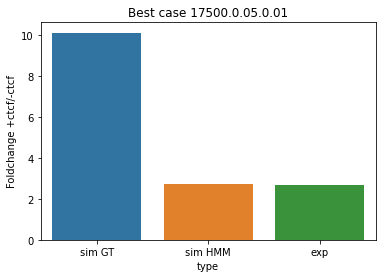

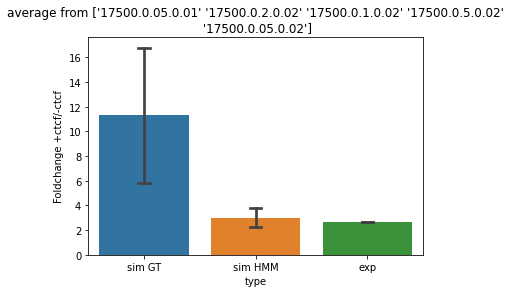

In [327]:
time_average = pd.DataFrame()
for realistic_select in realistic_list:

    subset_on = alldata[
        ["ctcfon.rad21on_" + realistic_select in x for x in alldata.condition]
    ].copy()
    subset_off = alldata[
        ["ctcfoff.rad21on_" + realistic_select in x for x in alldata.condition]
    ].copy()
    time = pd.DataFrame(
        [
            (1 - subset_on.bond.mean()) / (1 - subset_off.bond.mean()),
            (1 - subset_on.prediction.mean())
            / (1 - subset_off.prediction.mean()),
            0.677557 / 0.251439
        ],
        columns=["time"],
    )

    time["type"] = ["sim GT", "sim HMM", "exp"]
    if realistic_select == realistic_best:
        ax = sns.barplot(data=time, x="type", y="time")
        plt.ylabel("Foldchange +ctcf/-ctcf")
        plt.title(f"Best case {realistic_best}")
        pdf.savefig(ax.figure)
    time_average = pd.concat([time, time_average])

plt.figure()

ax = sns.barplot(data=time_average, x="type", y="time", ci="sd", capsize=.1, estimator = np.mean)
plt.ylabel("Foldchange +ctcf/-ctcf")
plt.title(f"average from {realistic_list}")
pdf.savefig(ax.figure)

# contact duration and second passage time of best case

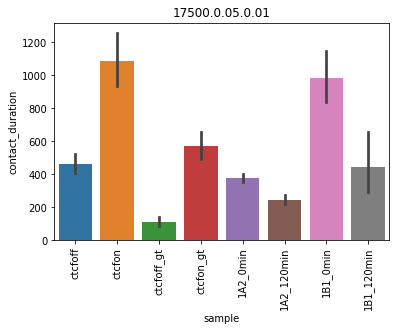

In [328]:
# simulation

cond = realistic_model_best
# cond = '17500.0.2_0.02'
distances_selected = distances[distances.condition == cond].iloc[::subsample_every].copy()

naked = distances_control.copy()

distances_selected.condition = distances_selected.uniqueid
(
    durations,
    second_passage_times,
    fraction_time,
    conditions,
    data_realistic,
) = calculate_duration_second_passage_time(
    distances_selected, resolution=30, model=results[cond]
)

(
    durations_gt,
    second_passage_times_gt,
    fraction_time_gt,
    conditions_gt,
    data_realistic_gt,
) = calculate_duration_second_passage_time(
    distances_selected, resolution=30, model=results[cond], gt=True
)

# Contact duration
durations["ctcf"] = durations.condition.str.split(".", expand=True)[0]
durations_gt["ctcf"] = durations_gt.condition.str.split(".", expand=True)[0]
durations_gt["ctcf"] = durations_gt["ctcf"] + "_gt"
exp_durations["ctcf"] = exp_durations["condition"]

durations = pd.concat([durations, durations_gt, exp_durations])
fig = plt.figure()
box_plot = sns.barplot(
    data=durations, x="ctcf", y="contact_duration"
)

ax = box_plot.axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.yscale('log')
plt.xlabel("sample")
plt.title(realistic_best)
plt.show()
pdf.savefig(box_plot.figure, bbox_inches='tight')

In [329]:
pd.DataFrame(durations.groupby("ctcf").mean()["contact_duration"]).to_csv(
    f"/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/contact_durations_exp_sim_neighbor_{nneighbor}.csv"
)

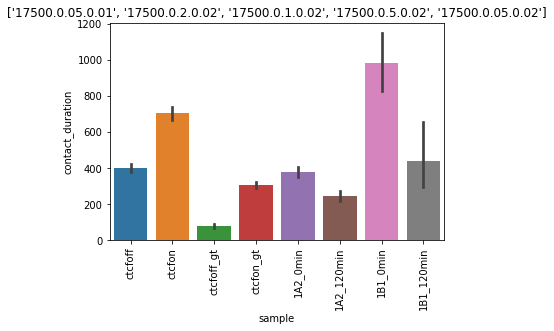

In [330]:
# simulation
durations_all = pd.DataFrame()
durations_all_gt = pd.DataFrame()
for cond in realistic_model_list:
    distances_selected = distances[distances.condition == cond].iloc[::subsample_every].copy()

    naked = distances_control.copy()

    distances_selected.condition = distances_selected.uniqueid
    (
        durations,
        second_passage_times,
        fraction_time,
        conditions,
        data_realistic,
    ) = calculate_duration_second_passage_time(
        distances_selected, resolution=30, model=results[cond]
    )
    
    durations_all = pd.concat([durations_all, durations])

    (
        durations_gt,
        second_passage_times_gt,
        fraction_time_gt,
        conditions_gt,
        data_realistic_gt,
    ) = calculate_duration_second_passage_time(
        distances_selected, resolution=30, model=results[cond], gt=True
    )
    durations_all_gt = pd.concat([durations_all_gt, durations_gt])
# Contact duration
durations_all["ctcf"] = durations_all.condition.str.split(".", expand=True)[0]
durations_all_gt["ctcf"] = durations_all_gt.condition.str.split(".", expand=True)[0]
durations_all_gt["ctcf"] = durations_all_gt["ctcf"] + "_gt"
exp_durations["ctcf"] = exp_durations["condition"]

durations_all = pd.concat([durations_all, durations_all_gt, exp_durations])
fig = plt.figure()
box_plot = sns.barplot(
    data=durations_all, x="ctcf", y="contact_duration"
)

ax = box_plot.axes
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.yscale('log')
plt.xlabel("sample")
plt.title(list(realistic_list))
plt.show()
pdf.savefig(box_plot.figure, bbox_inches='tight')

In [331]:
durations_all.groupby("ctcf").mean()["contact_duration"]

ctcf
1A2_0min      378.529412
1A2_120min    245.957447
1B1_0min      981.293706
1B1_120min    442.500000
ctcfoff       401.884058
ctcfoff_gt     79.277108
ctcfon        703.801843
ctcfon_gt     306.904588
Name: contact_duration, dtype: float64

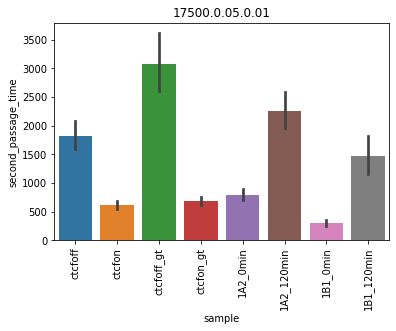

In [296]:
# Second passage time

second_passage_times["ctcf"] = second_passage_times.condition.str.split(".", expand=True)[0]
second_passage_times_gt["ctcf"] = second_passage_times_gt.condition.str.split(".", expand=True)[0]
second_passage_times_gt["ctcf"] = second_passage_times_gt["ctcf"] + "_gt"
exp_second_passage_times["ctcf"] = exp_second_passage_times["condition"]

second_passage_times = pd.concat([second_passage_times, second_passage_times_gt, exp_second_passage_times])
fig = plt.figure()
box_plot = sns.barplot(
    data=second_passage_times, x="ctcf", y="second_passage_time"
)

ax = box_plot.axes
# lines = ax.get_lines()
# categories = ax.get_xticks()


# for cat in categories:
#     y = round(lines[4 + cat * 6].get_ydata()[0], 1)

#     ax.text(
#         cat,
#         y,
#         f"{y}",
#         ha="center",
#         va="center",
#         fontweight="bold",
#         size=10,
#         color="white",
#         bbox=dict(facecolor="#445A64"),
#     )

# box_plot.figure.tight_layout()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# plt.yscale('log')
plt.xlabel("sample")
plt.title(realistic_best)
plt.show()
pdf.savefig(box_plot.figure, bbox_inches='tight')

In [297]:
pd.DataFrame(second_passage_times.groupby("ctcf").mean()["second_passage_time"]).to_csv(
    f"/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/second_passage_times_exp_sim_{nneighbor}.csv"
)

# distance distribution of best  case and comparison with experimental data

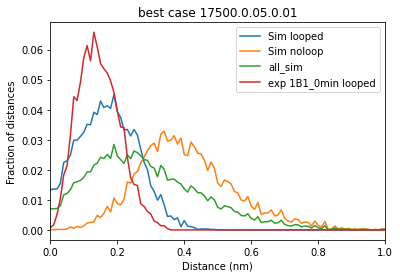

In [298]:
best_subset = alldata[["rad21on_" + realistic_best in x for x in alldata.condition]].copy()
best_subset_on = best_subset[best_subset.ctcf=="on"].copy()
best_subset_off = best_subset[best_subset.ctcf=="off"].copy()
dist = exp_data_filtered[(exp_data_filtered.condition == "1B1_0min")].copy()

distance = dist.distance.values.reshape(-1, 1)
states = (exp_model.predict(distance))
dist['states'] = states
dist["states_numeric"] = dist.states.values
dist.states.replace(0, "looped", inplace=True)
dist.states.replace(1, "unlooped", inplace=True)

hists = []
hist = plt.hist(best_subset_on.distance[best_subset_on.prediction==0], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(best_subset_on.distance[best_subset_on.prediction==1], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(best_subset_on.distance, density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(dist.distance[dist.states == "looped"], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)
plt.close()

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))
plt.xlim(0,1)
plt.xlabel("Distance (nm)")
plt.ylabel("Fraction of distances")
plt.legend(["Sim looped", "Sim noloop", "all_sim", "exp 1B1_0min looped"])
plt.title(f"best case {realistic_best}")
pdf.savefig(fig)

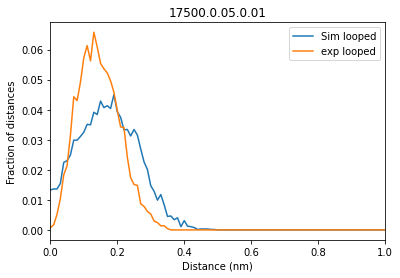

In [299]:
hists = []
hist = plt.hist(best_subset_on.distance[best_subset_on.prediction==0], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(dist.distance[dist.states=="looped"], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

plt.close()

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))
plt.xlim(0,1)
plt.xlabel("Distance (nm)")
plt.ylabel("Fraction of distances")
plt.legend(["Sim looped", "exp looped"])
plt.title(realistic_best)
pdf.savefig(fig)

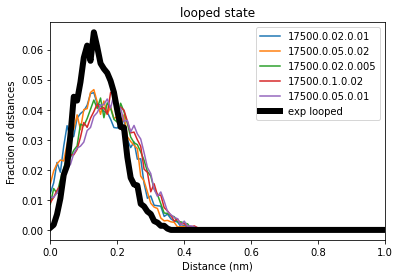

In [300]:
conditions = dist_together.sort_values('dist_gaussian_means').head(5).realistic

hists = []
for cond in conditions:
    subset_on = alldata[["rad21on_" + cond in x for x in alldata.condition]].copy()
    hist = plt.hist(subset_on.distance[subset_on.prediction==0], alpha=0.3, bins=np.arange(0,5,0.01))
    hists.append(hist)


hist=plt.hist(dist.distance[dist.states=="looped"], alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)
conditions = np.append(conditions , "exp looped")
plt.close()

fig = plt.figure()
for hist in hists[:-1]:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))
    
plt.plot(hists[-1][1][:-1], hists[-1][0]/np.sum(hists[-1][0]), color='black', linewidth=6)
plt.xlim(0,1)
plt.xlabel("Distance (nm)")
plt.ylabel("Fraction of distances")
plt.legend(conditions)
plt.title("looped state")
pdf.savefig(fig)

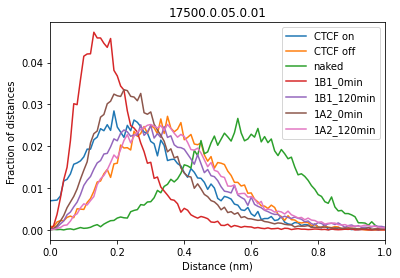

In [301]:
hists = []
hist=plt.hist(best_subset_on.distance, density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(best_subset_off.distance, density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(distances_control.distance, density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(exp.distance[exp.condition == "1B1_0min"], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(exp.distance[exp.condition == "1B1_120min"], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(exp.distance[exp.condition == "1A2_0min"], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

hist=plt.hist(exp.distance[exp.condition == "1A2_120min"], density=True, alpha=0.3, bins=np.arange(0,5,0.01))
hists.append(hist)

plt.close()

fig = plt.figure()
for hist in hists:
    plt.plot( hist[1][:-1], hist[0]/np.sum(hist[0]))
plt.xlim(0,1)
plt.xlabel("Distance (nm)")
plt.ylabel("Fraction of distances")
plt.legend(["CTCF on", "CTCF off", "naked", "1B1_0min", "1B1_120min", "1A2_0min", "1A2_120min"])
plt.title(realistic_best)
pdf.savefig(fig)

# Example tracks with GT and prediction

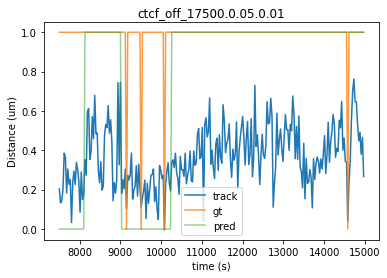

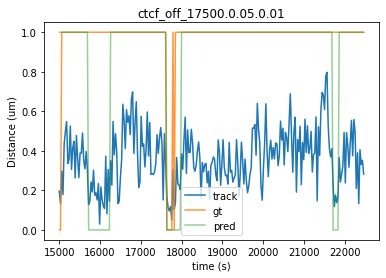

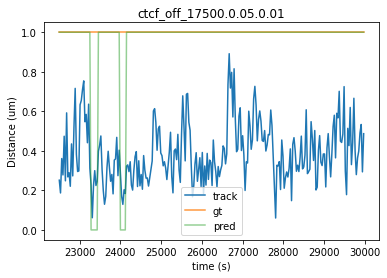

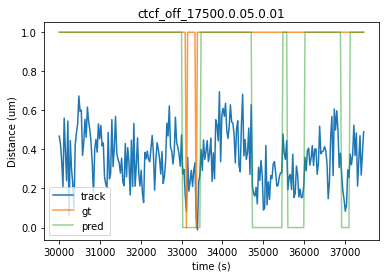

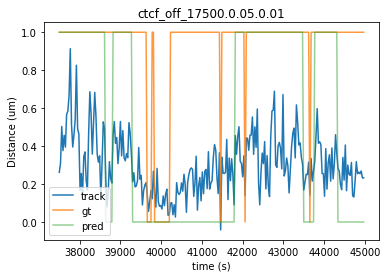

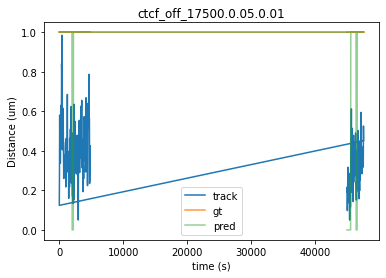

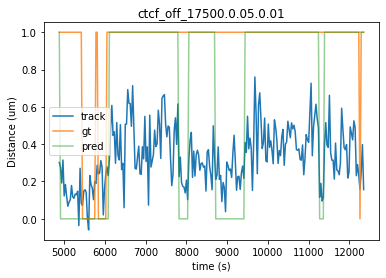

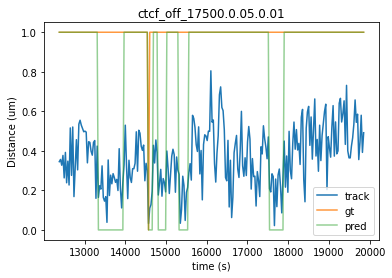

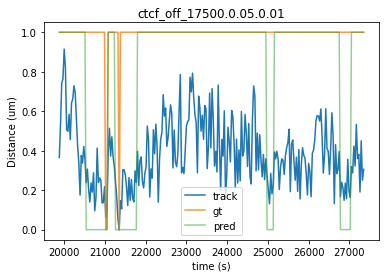

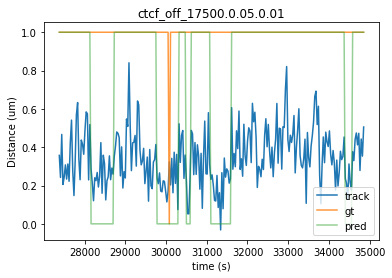

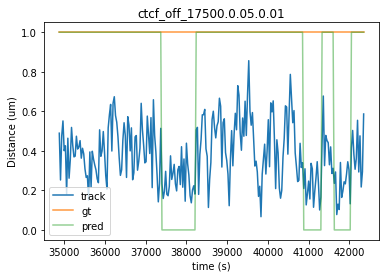

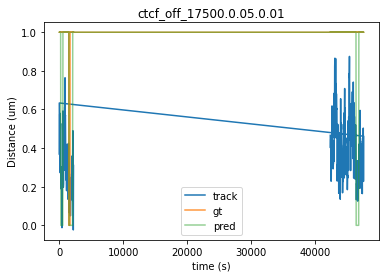

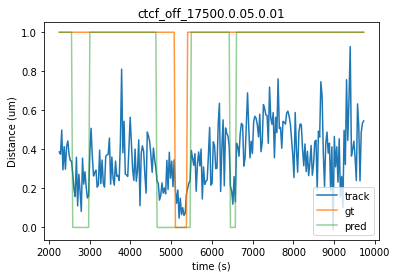

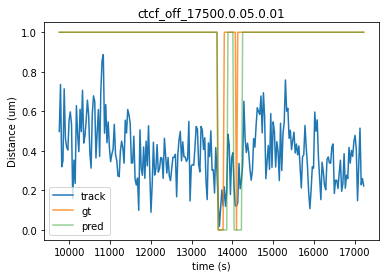

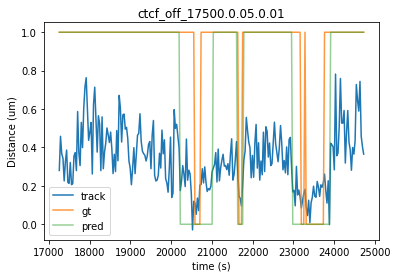

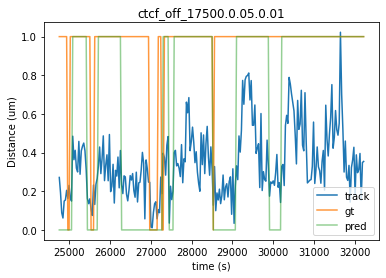

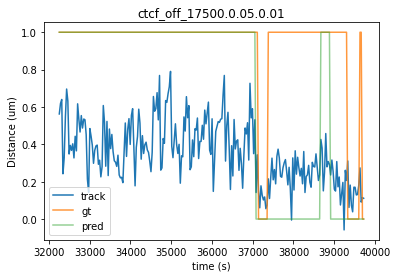

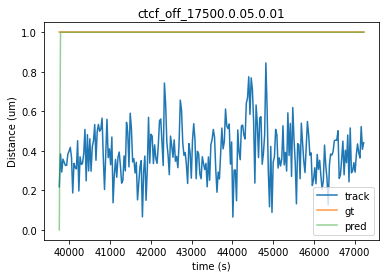

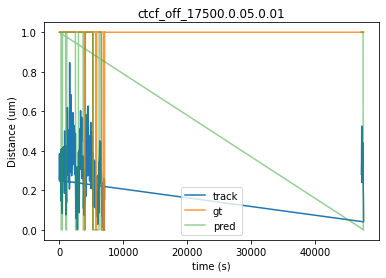

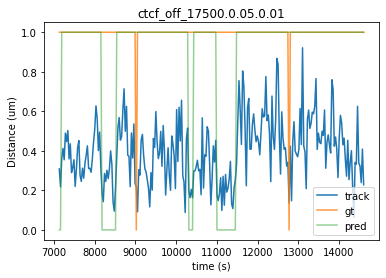

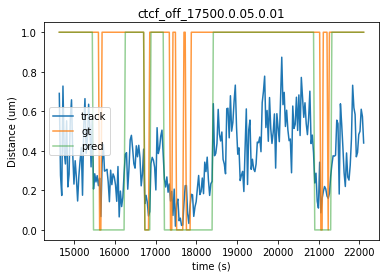

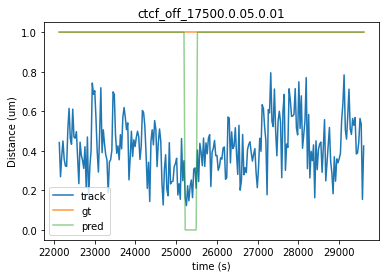

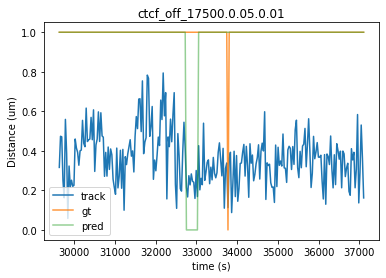

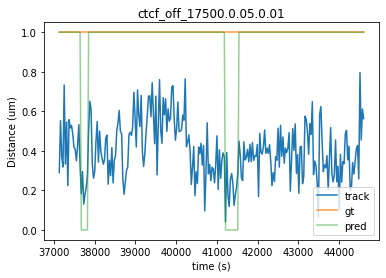

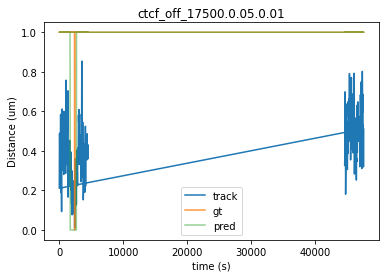

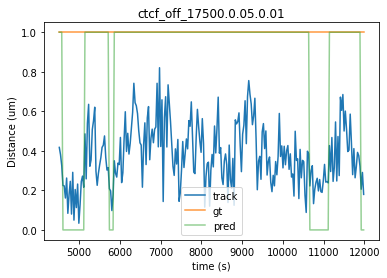

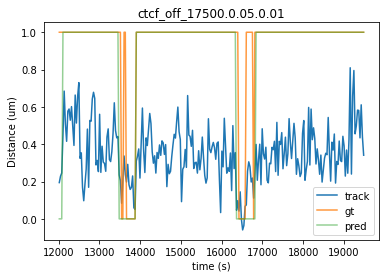

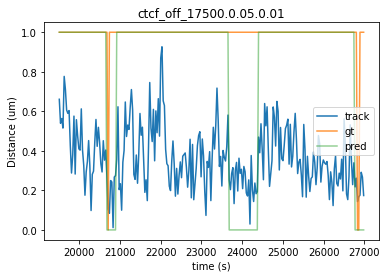

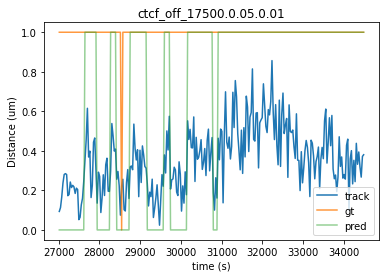

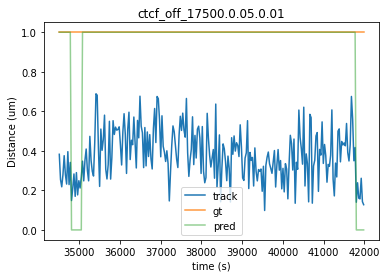

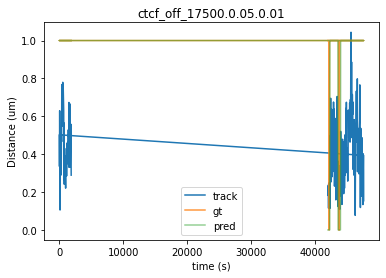

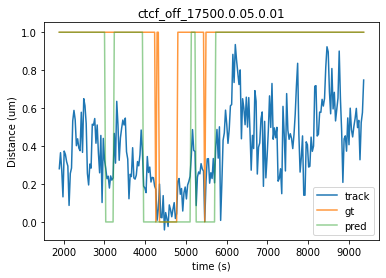

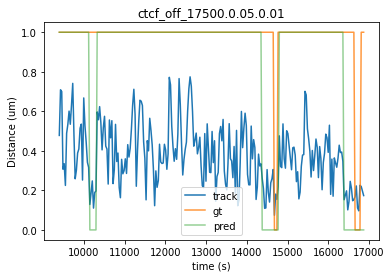

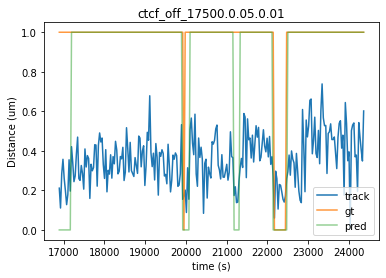

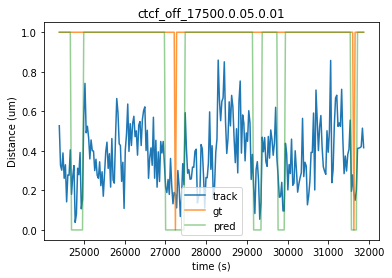

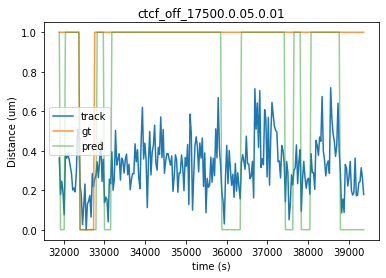

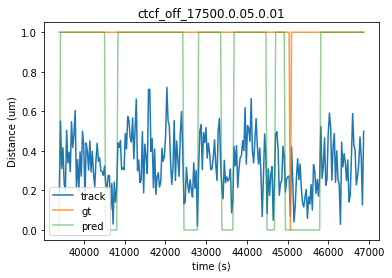

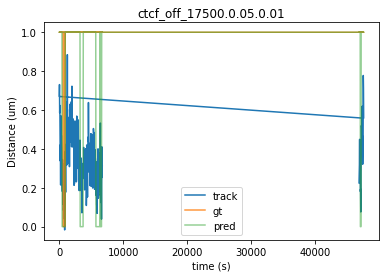

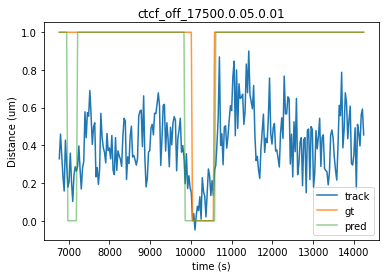

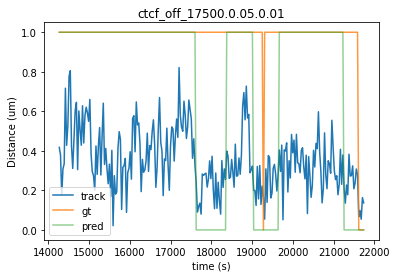

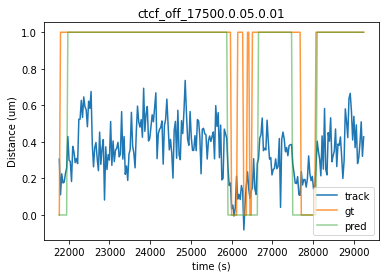

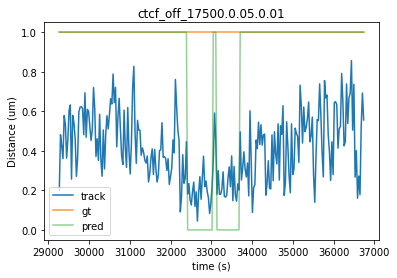

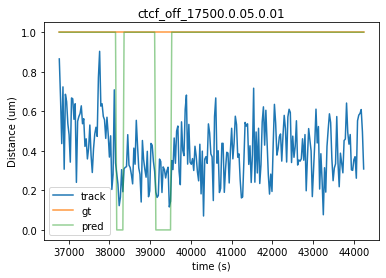

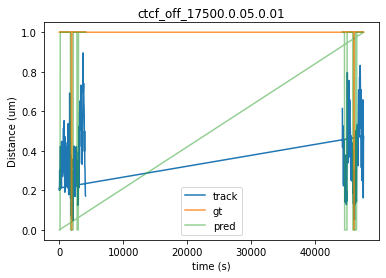

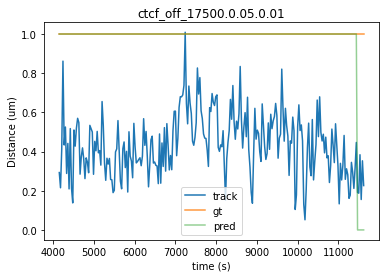

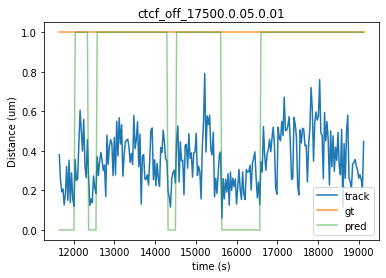

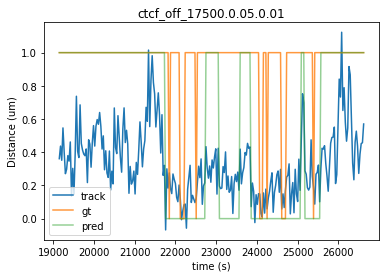

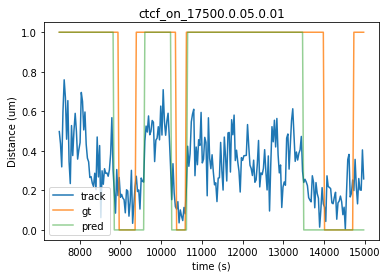

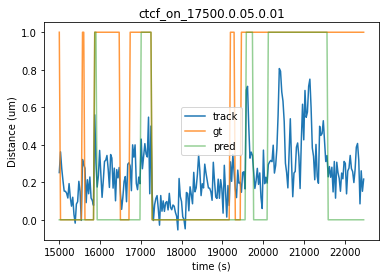

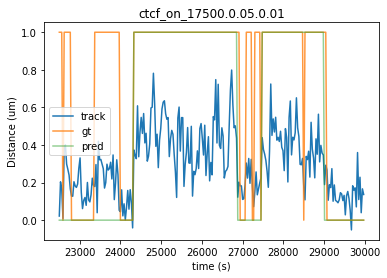

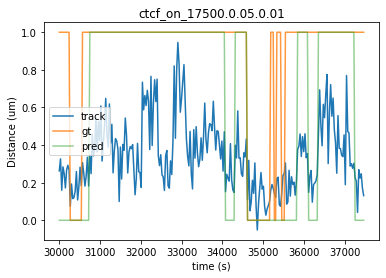

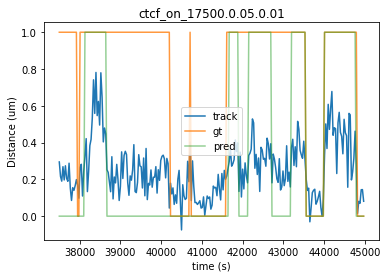

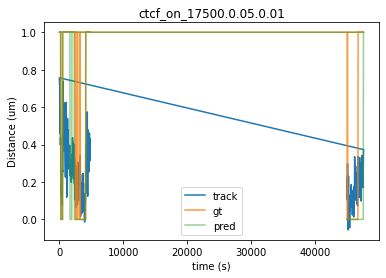

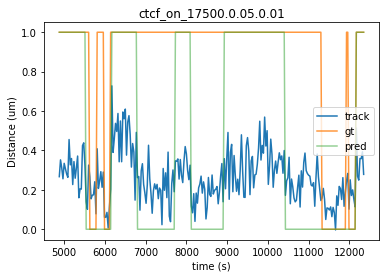

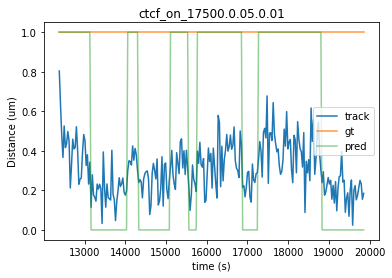

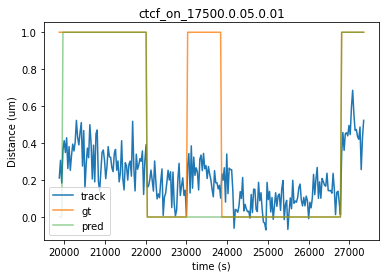

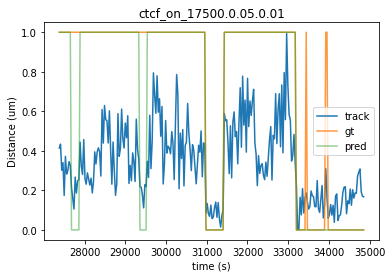

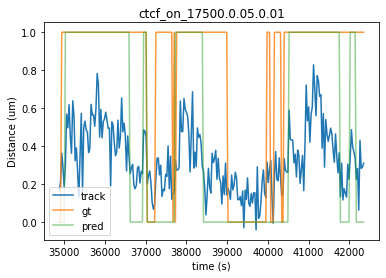

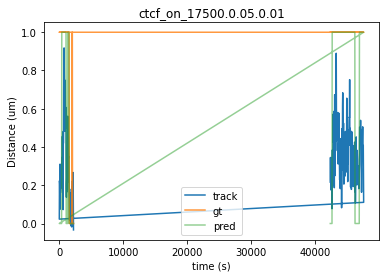

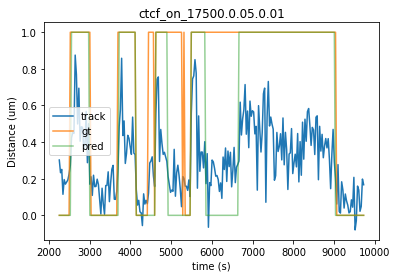

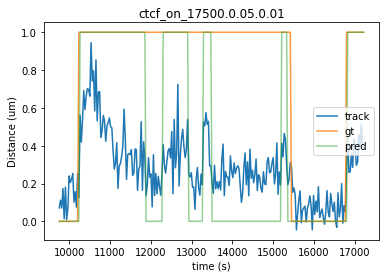

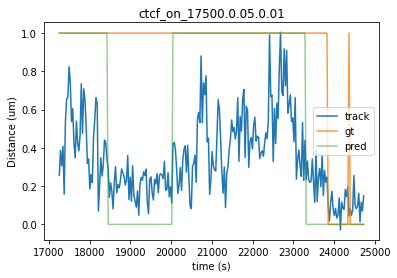

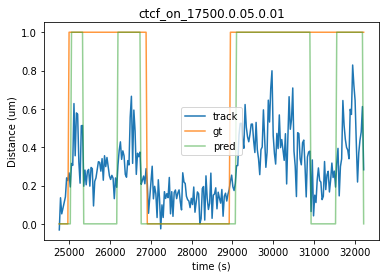

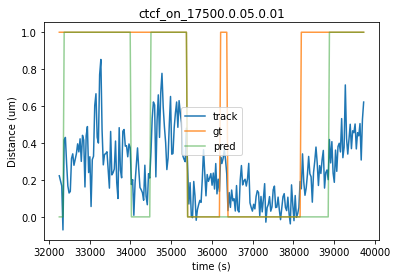

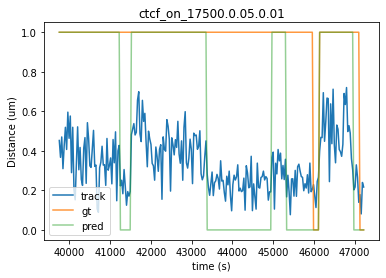

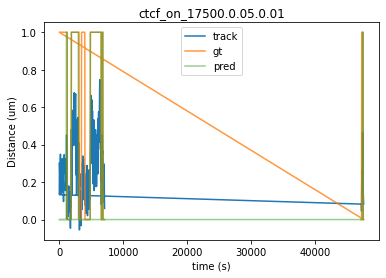

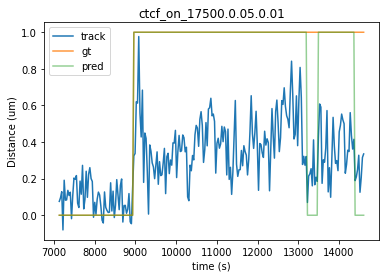

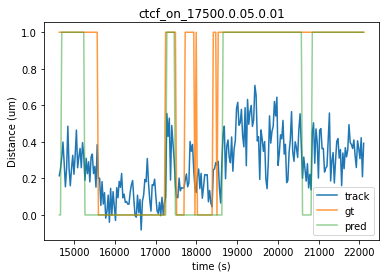

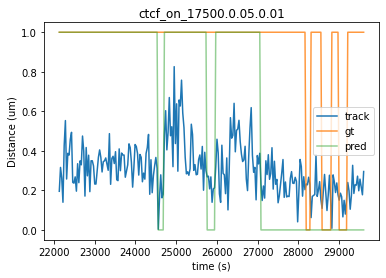

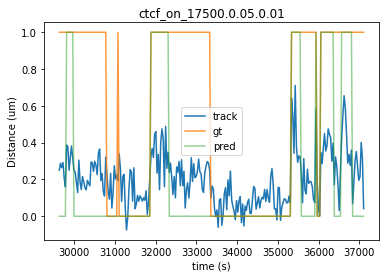

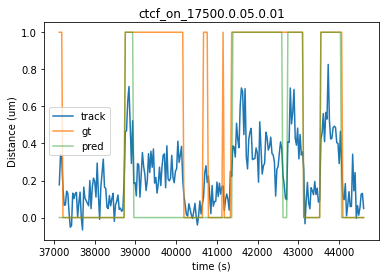

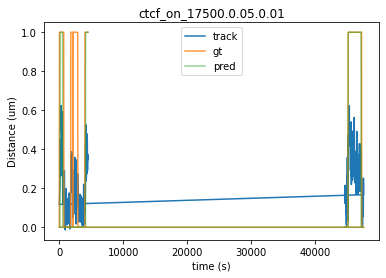

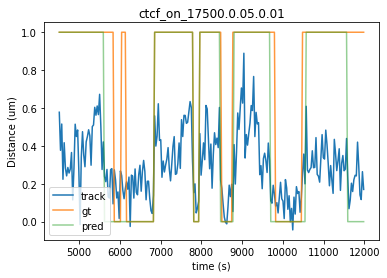

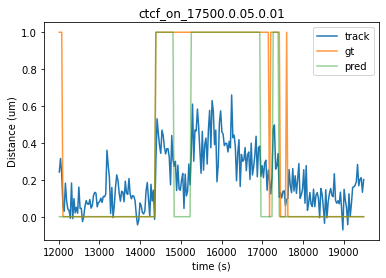

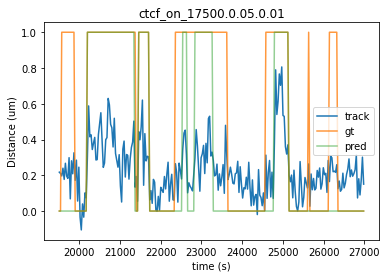

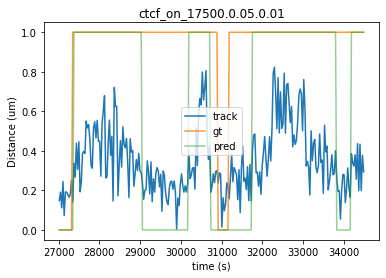

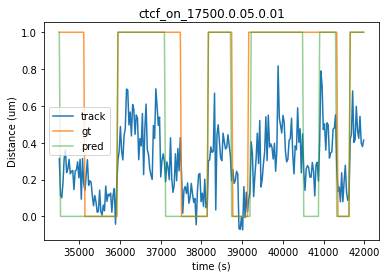

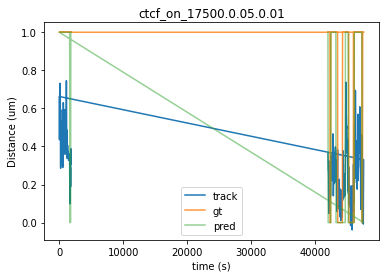

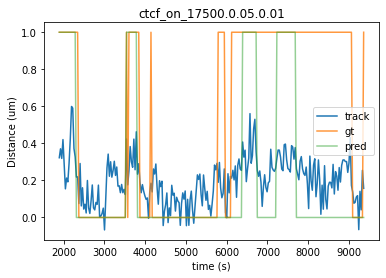

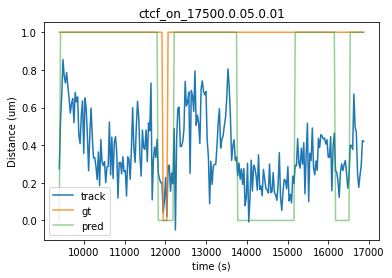

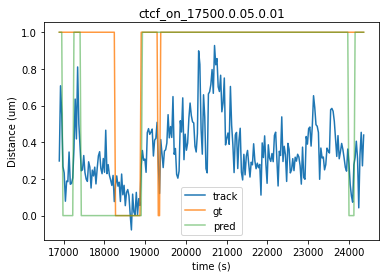

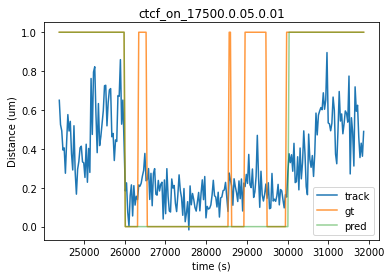

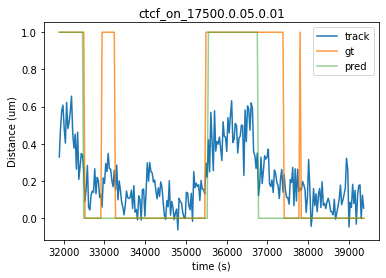

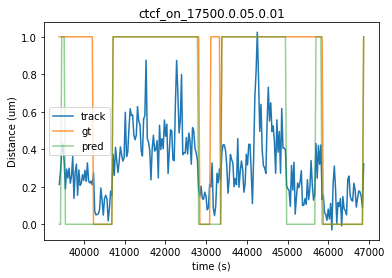

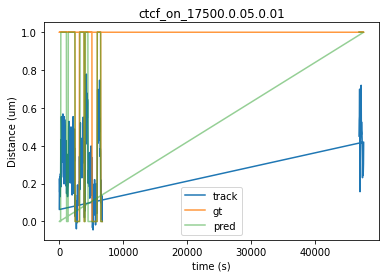

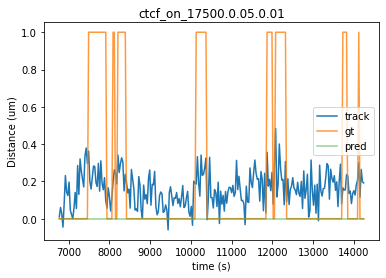

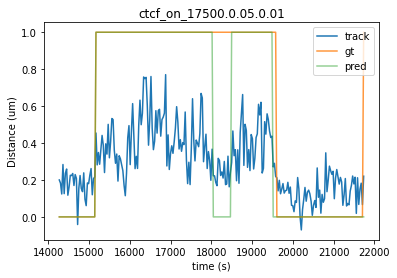

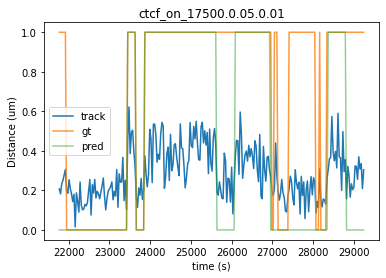

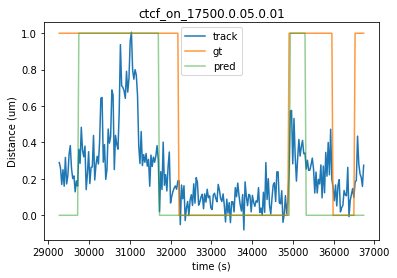

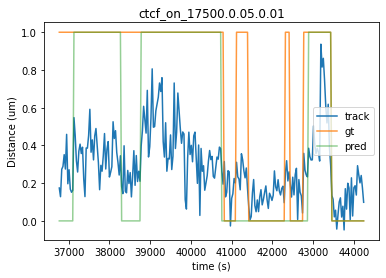

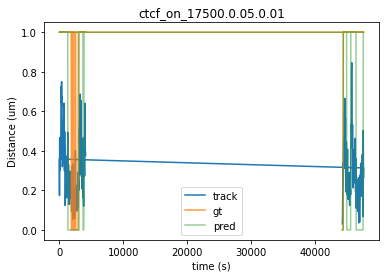

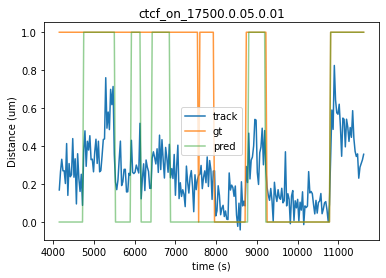

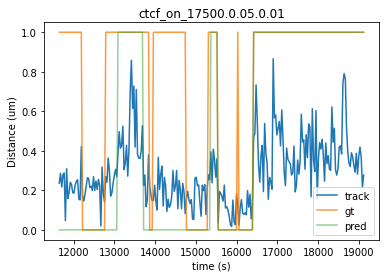

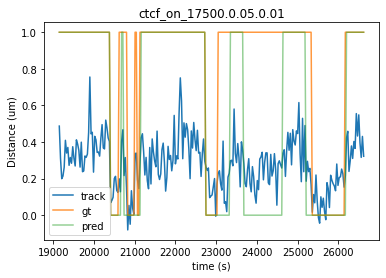

In [302]:
# +/- ctcf tracks
for ctcf, sub in best_subset.groupby("ctcf"):
    for limitstart in range(250,12000, 250):
        limit = limitstart + 250
        fig = plt.figure()
        plt.plot(sub.frame.values[limitstart:limit]*30, sub.distance.values[limitstart:limit])
        plt.plot(sub.frame.values[limitstart:limit]*30, sub.bond.values[limitstart:limit], alpha=0.8)
        plt.plot(sub.frame.values[limitstart:limit]*30, sub.prediction.values[limitstart:limit], alpha=0.5)
        plt.legend(['track', 'gt', 'pred'])
        plt.xlabel("time (s)")
        plt.ylabel("Distance (um)")
        plt.title("ctcf_" + ctcf + "_" + realistic_best)
        plt.show()
        plt.ylim(-0.2,1.2)
        pdf.savefig(fig)
        plt.close()

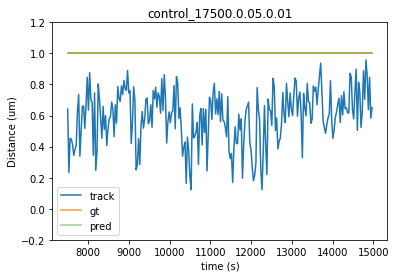

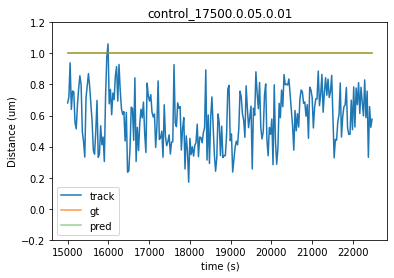

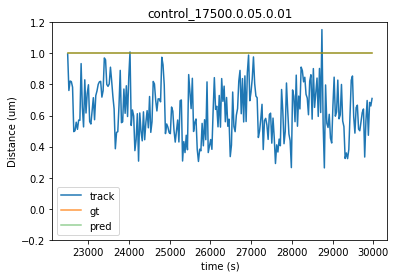

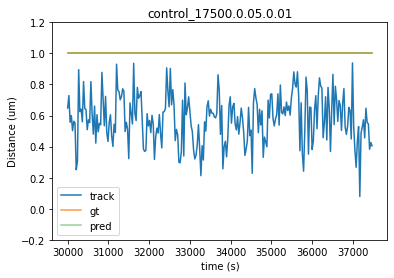

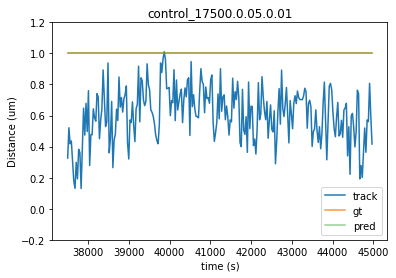

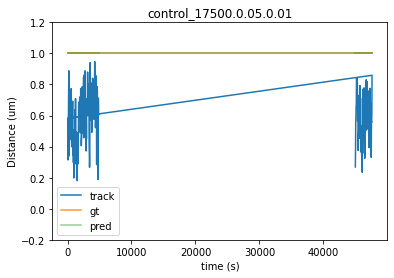

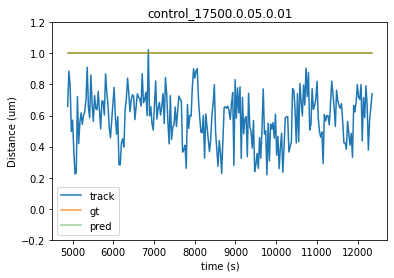

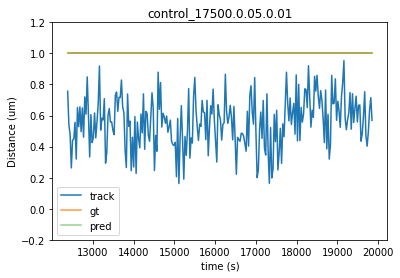

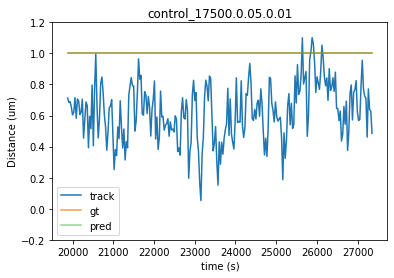

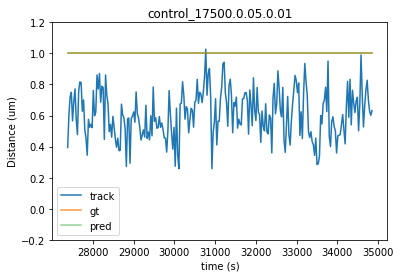

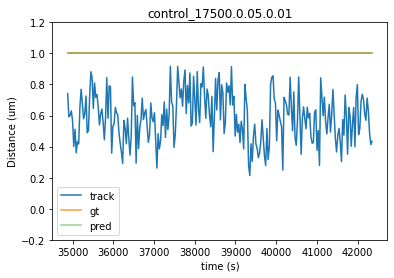

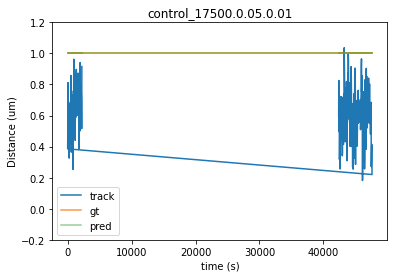

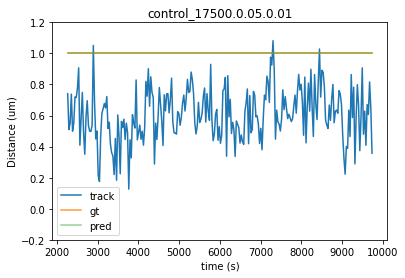

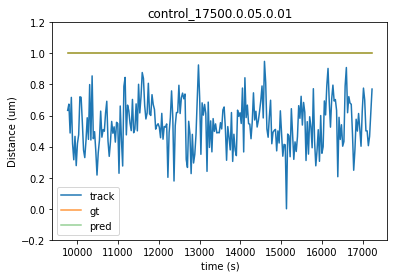

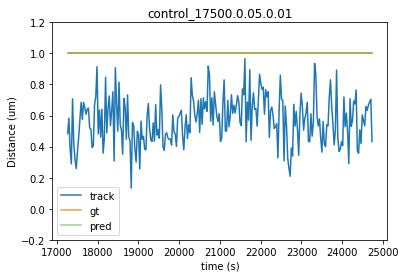

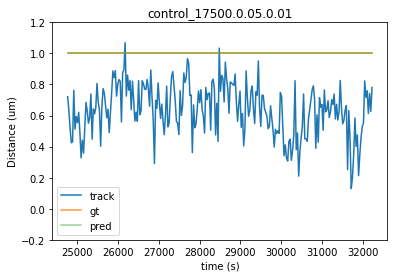

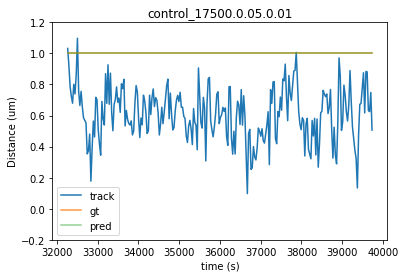

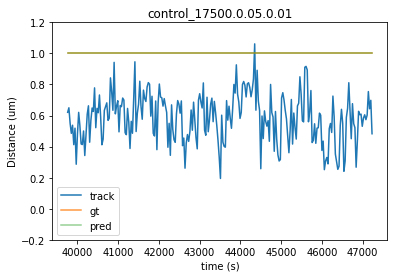

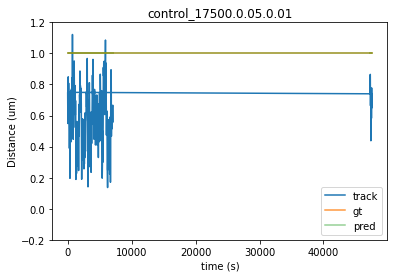

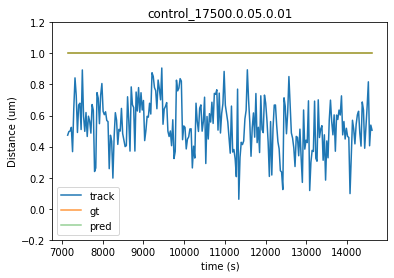

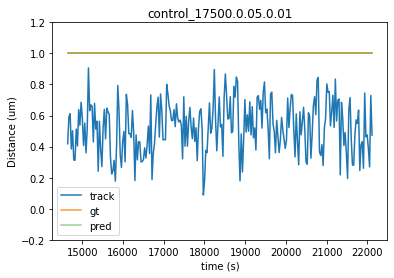

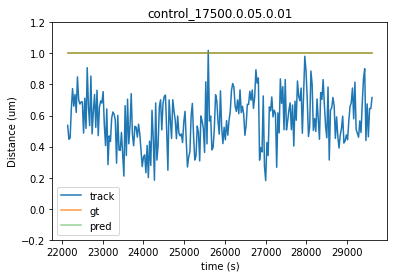

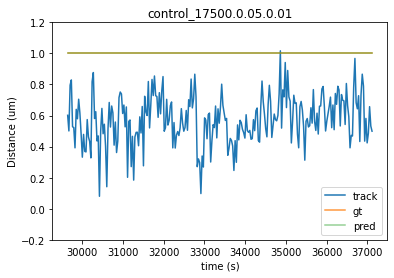

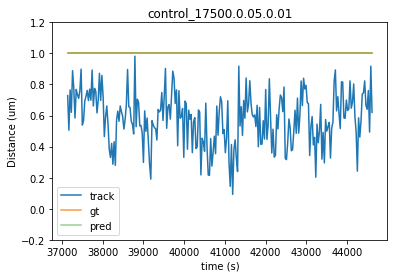

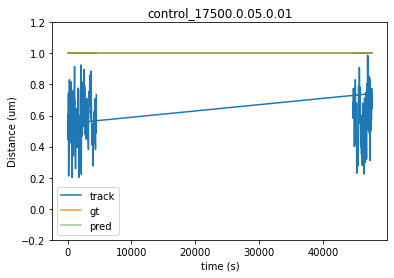

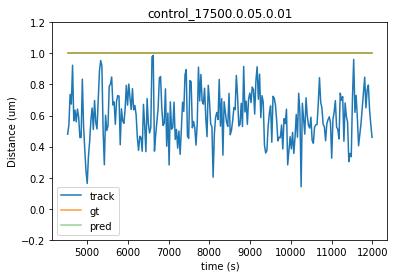

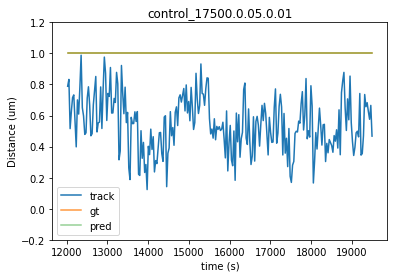

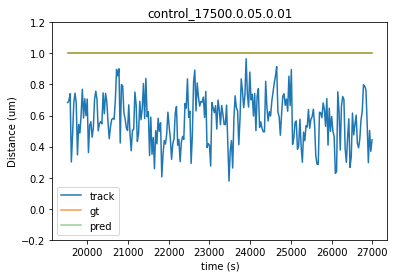

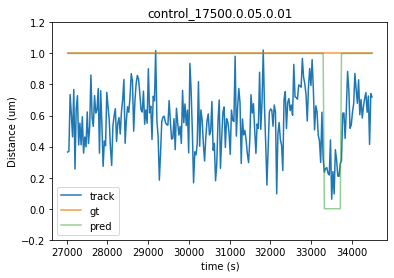

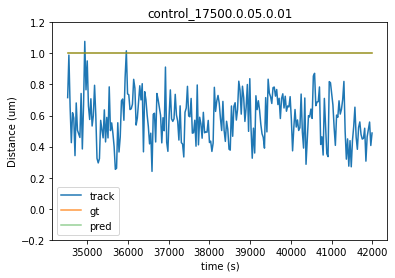

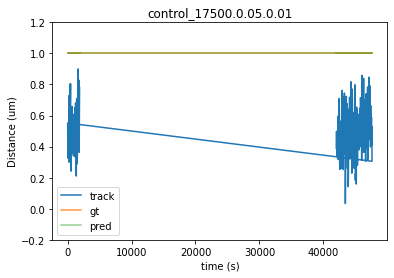

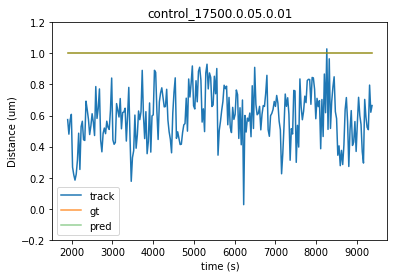

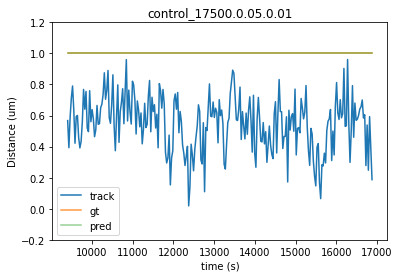

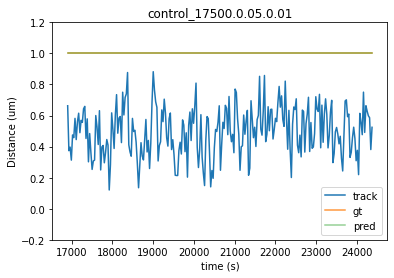

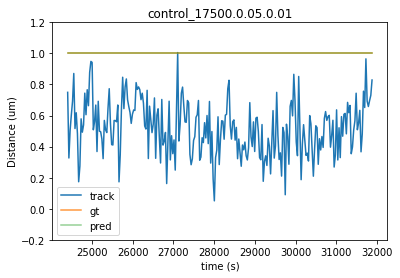

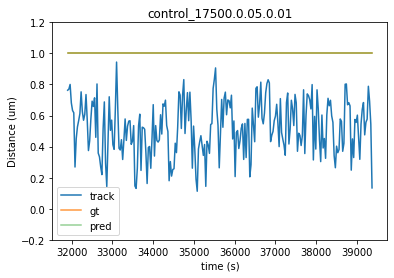

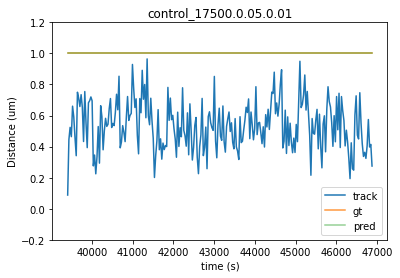

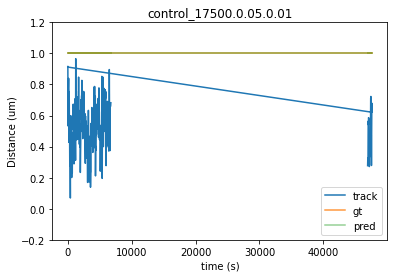

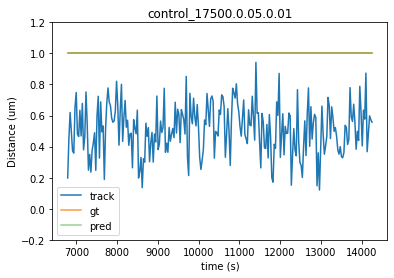

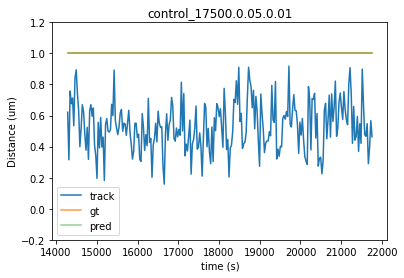

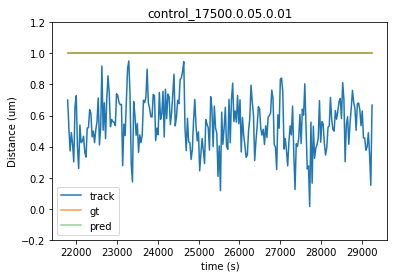

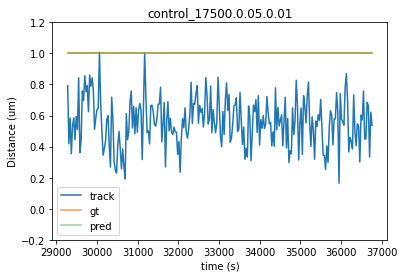

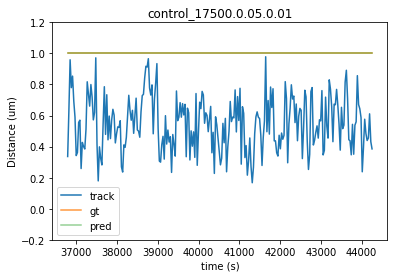

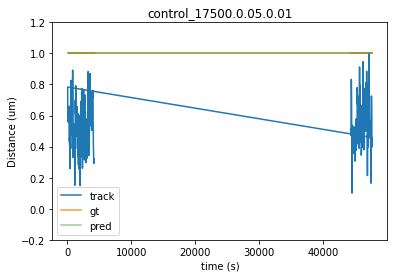

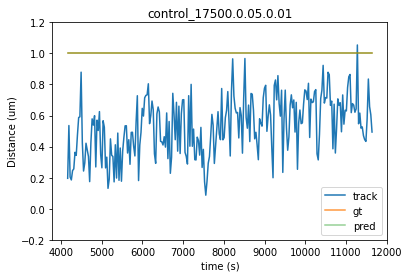

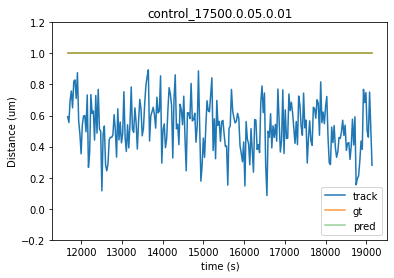

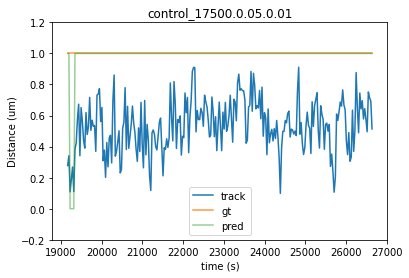

In [303]:
# naked polymer

traj = distances_control.distance.values.reshape(-1, 1)
m = results[realistic_model_best]
distances_control["prediction"] = m.predict(traj)

sub = distances_control.copy()
for limitstart in range(250,12000, 250):
    limit = limitstart + 250
    fig = plt.figure()
    
    plt.plot(sub.frame.values[limitstart:limit]*30, sub.distance.values[limitstart:limit])
    plt.plot(sub.frame.values[limitstart:limit]*30, sub.bond.values[limitstart:limit], alpha=0.8)
    plt.plot(sub.frame.values[limitstart:limit]*30, sub.prediction.values[limitstart:limit], alpha=0.5)
    plt.legend(['track', 'gt', 'pred'])
    plt.xlabel("time (s)")
    plt.ylabel("Distance (um)")
    plt.title("control_" + realistic_best)
    plt.ylim(-0.2,1.2)
    plt.show()
    pdf.savefig(fig)
    plt.close()

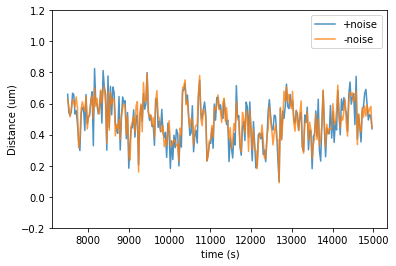

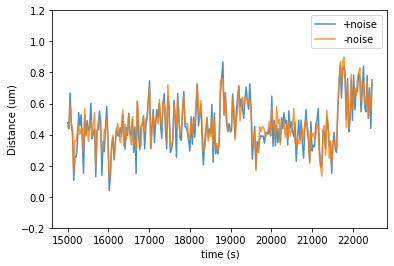

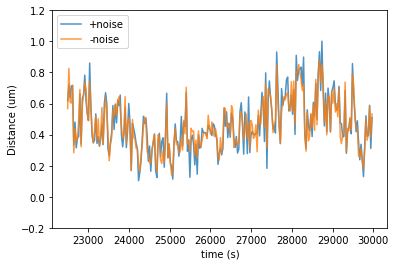

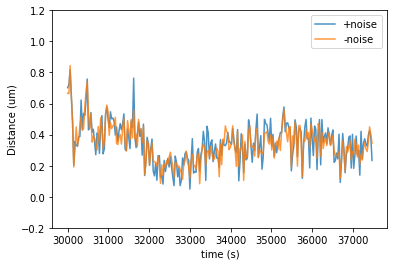

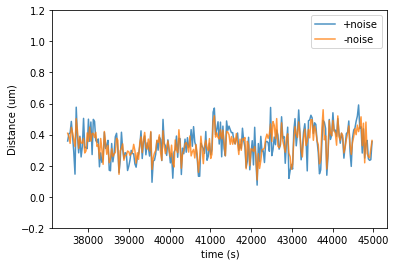

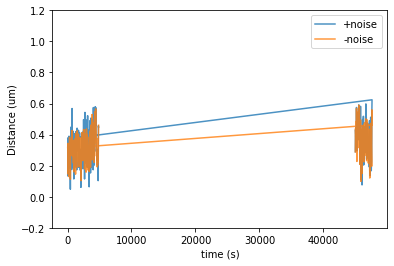

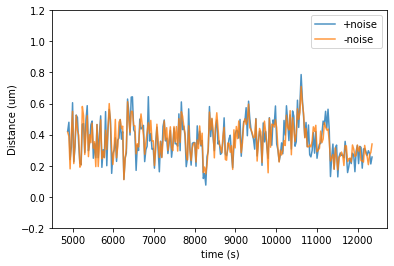

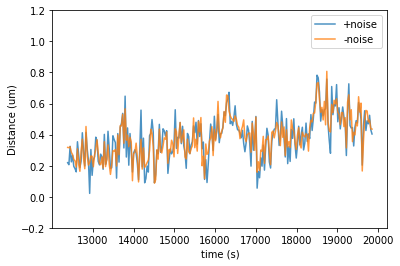

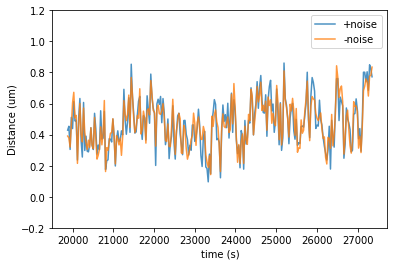

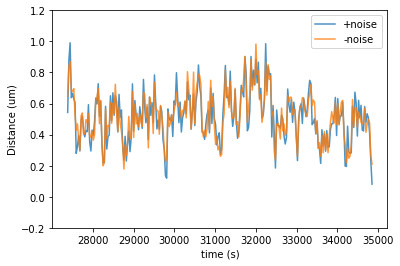

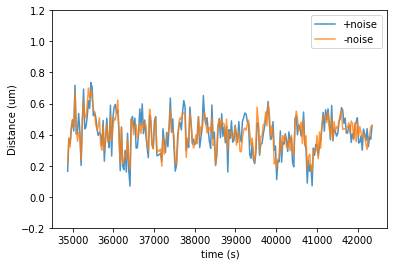

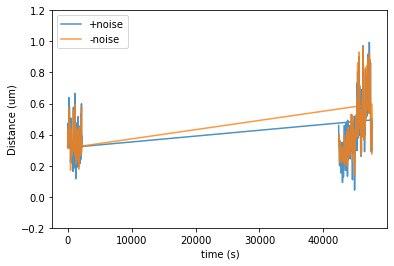

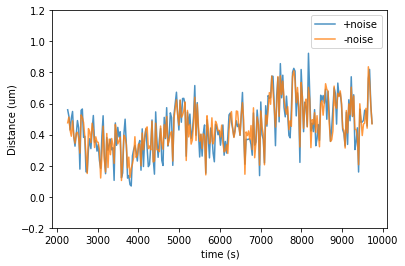

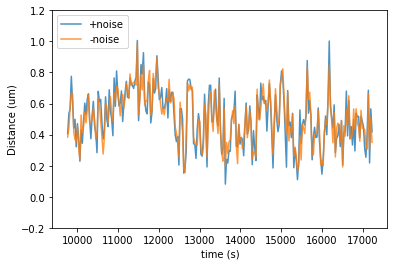

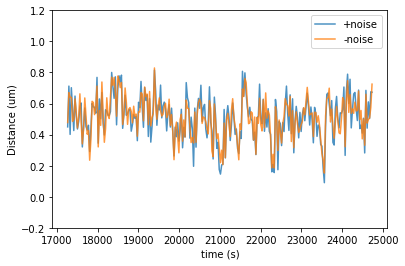

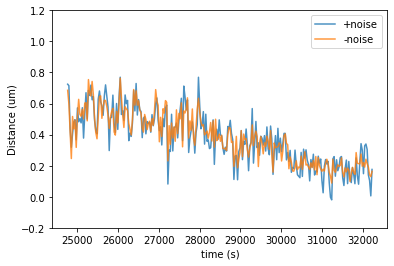

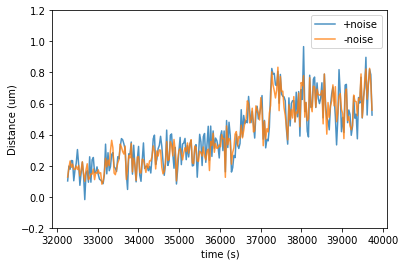

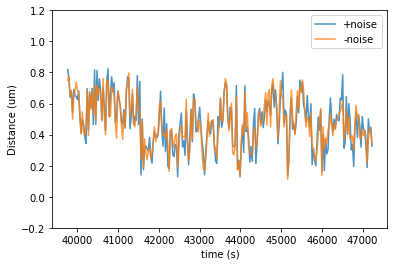

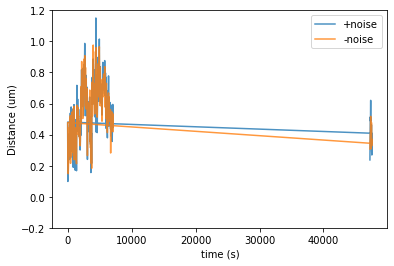

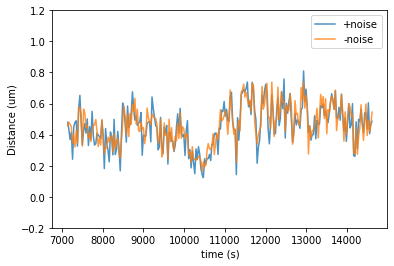

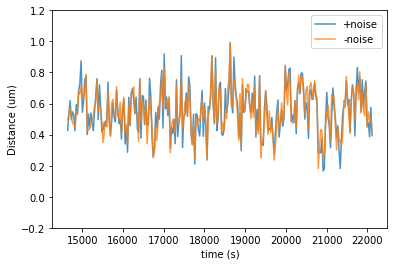

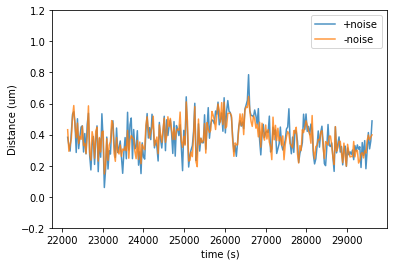

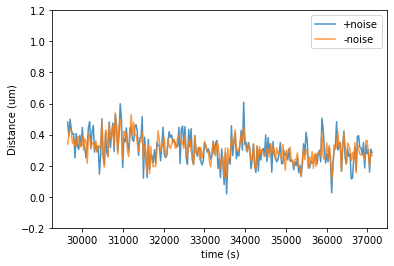

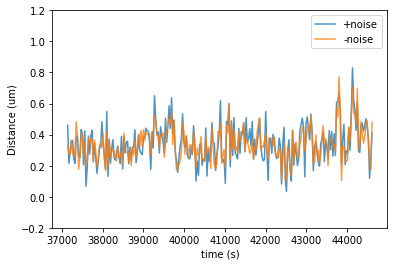

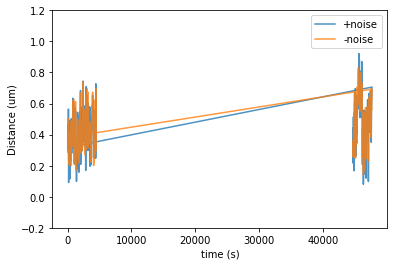

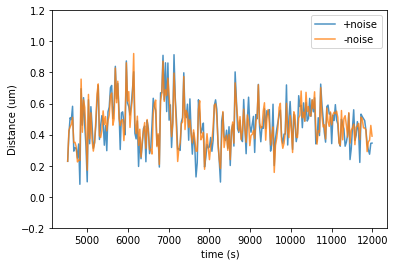

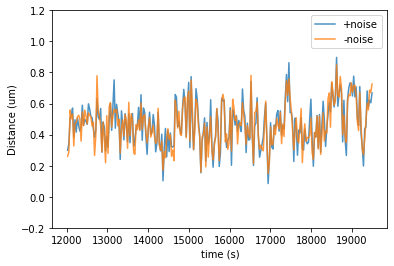

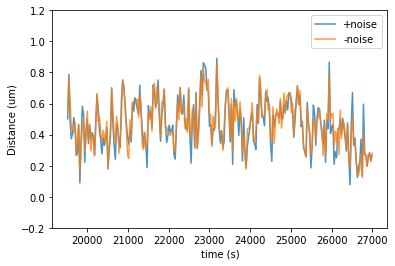

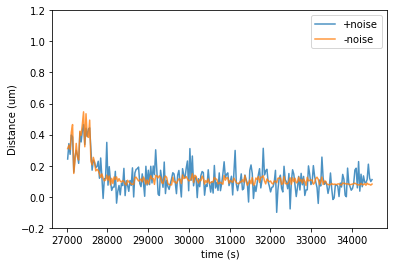

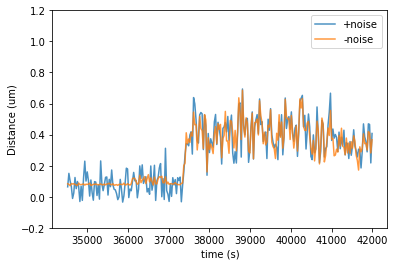

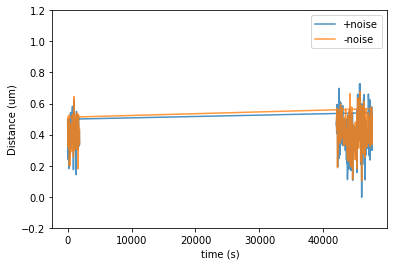

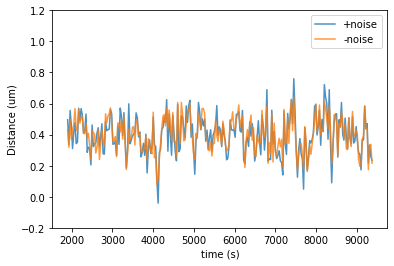

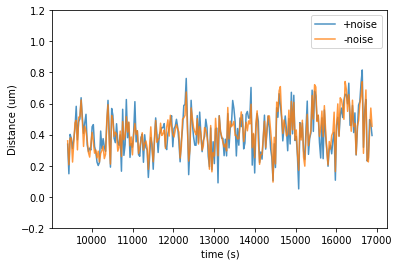

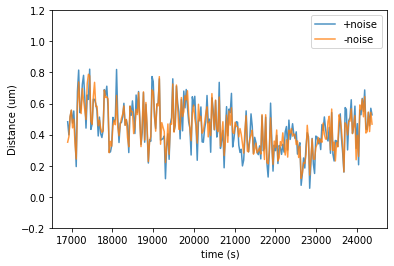

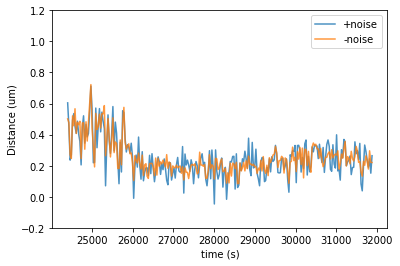

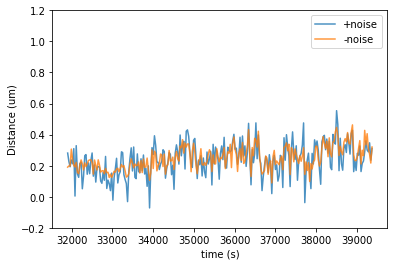

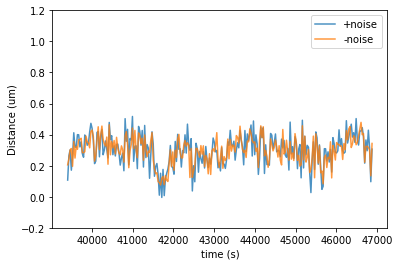

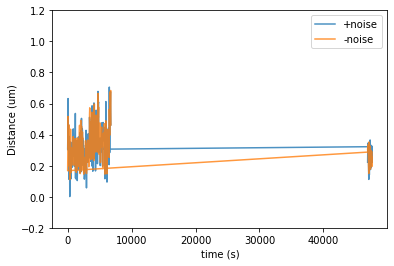

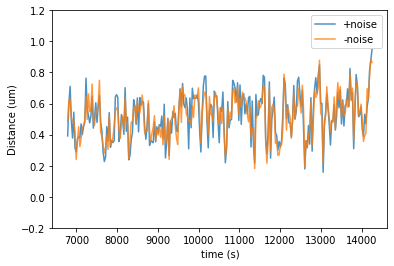

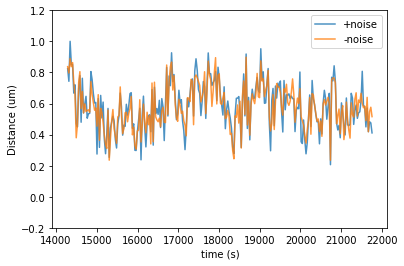

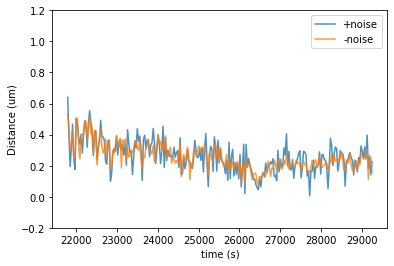

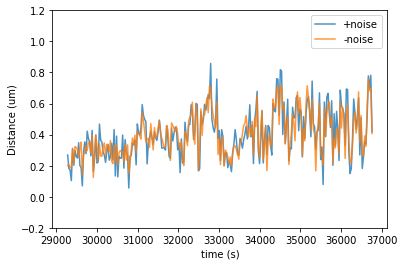

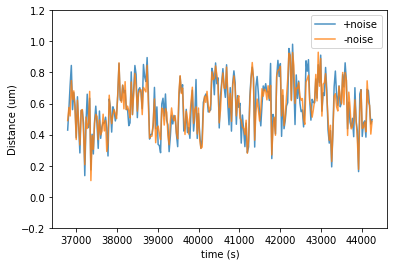

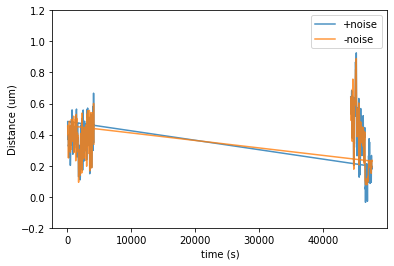

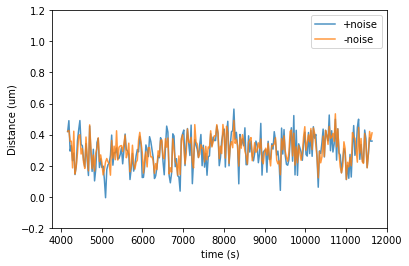

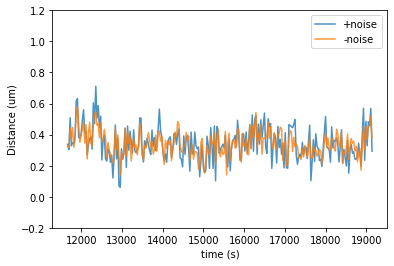

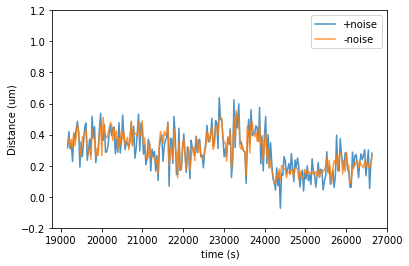

In [304]:
distances_nonoise = distances_original.iloc[::30].copy()
for limitstart in range(250,12000, 250):
    limit = limitstart + 250
    fig = plt.figure()
    
    plt.plot(distances.frame.values[limitstart:limit]*30, distances.distance.values[limitstart:limit], alpha=0.8)
    plt.plot(distances.frame.values[limitstart:limit]*30, distances_nonoise.distance.values[limitstart:limit], alpha=0.8)
    plt.legend(['+noise', '-noise'])
    plt.xlabel("time (s)")
    plt.ylabel("Distance (um)")
    plt.ylim(-0.2,1.2)
    plt.show()
    pdf.savefig(fig)
    plt.close()

In [305]:
pdf.close()

# pvalues of differences

In [223]:
import scipy
import scipy.stats

In [41]:
# contact durations
test = scipy.stats.ttest_ind(
    durations.contact_duration[durations.ctcf == "ctcfoff"].values,
    durations.contact_duration[durations.ctcf == "ctcfon"].values,
)
print(f"ctcf on vs ctcf off HMM simulation pvalue from two sided t.test: {test.pvalue}")

test = scipy.stats.ttest_ind(
    durations.contact_duration[durations.ctcf == "ctcfoff_gt"].values,
    durations.contact_duration[durations.ctcf == "ctcfon_gt"].values,
)
print(f"ctcf on vs ctcf off GT simulation pvalue from two sided t.test {test.pvalue}")

test = scipy.stats.ttest_ind(
    durations.contact_duration[durations.ctcf == "1B1_0min"].values,
    durations.contact_duration[durations.ctcf == "1A2_0min"].values,
)
print(f"1B1_0min vs 1A2_0min pvalue from two sided t.test {test.pvalue}")

test = scipy.stats.ttest_ind(
    durations.contact_duration[durations.ctcf == "1B1_0min"].values,
    durations.contact_duration[durations.ctcf == "1A2_120min"].values,
)
print(f"1B1_0min vs 1A2_120min pvalue from two sided t.test {test.pvalue}")

test = scipy.stats.ttest_ind(
    durations.contact_duration[durations.ctcf == "1B1_0min"].values,
    durations.contact_duration[durations.ctcf == "1B1_120min"].values,
)
print(f"1B1_0min vs 1B1_120min pvalue from two sided t.test {test.pvalue}")

# test = scipy.stats.ttest_ind(
#     durations.contact_duration[durations.ctcf == "1A2_0min"].values,
#     durations.contact_duration[durations.ctcf == "1B1_120min"].values,
# )
# print(f"1A2_0min vs 1B1_120min pvalue from two sided t.test {test.pvalue}")

# test = scipy.stats.ttest_ind(
#     durations.contact_duration[durations.ctcf == "1A2_0min"].values,
#     durations.contact_duration[durations.ctcf == "1A2_120min"].values,
# )
# print(f"1A2_0min vs 1A2_120min pvalue from two sided t.test {test.pvalue}")

# test = scipy.stats.ttest_ind(
#     durations.contact_duration[durations.ctcf == "1B1_120min"].values,
#     durations.contact_duration[durations.ctcf == "1A2_120min"].values,
# )
# print(f"1B1_120min vs 1A2_120min pvalue from two sided t.test {test.pvalue}")


ctcf on vs ctcf off HMM simulation pvalue from two sided t.test: 3.0283522532153246e-11
ctcf on vs ctcf off GT simulation pvalue from two sided t.test 3.06974660659959e-13
1B1_0min vs 1A2_0min pvalue from two sided t.test 5.924377061844856e-22
1B1_0min vs 1A2_120min pvalue from two sided t.test 3.8800663361850724e-10
1B1_0min vs 1B1_120min pvalue from two sided t.test 0.0010827677171693932


In [42]:
# second_passage_times
test = scipy.stats.ttest_ind(
    second_passage_times.second_passage_time[second_passage_times.ctcf == "ctcfoff"].values,
    second_passage_times.second_passage_time[second_passage_times.ctcf == "ctcfon"].values,
)
print(f"ctcf on vs ctcf off HMM simulation pvalue from two sided t.test: {test.pvalue}")

test = scipy.stats.ttest_ind(
    second_passage_times.second_passage_time[second_passage_times.ctcf == "ctcfoff_gt"].values,
    second_passage_times.second_passage_time[second_passage_times.ctcf == "ctcfon_gt"].values,
)
print(f"ctcf on vs ctcf off GT simulation pvalue from two sided t.test {test.pvalue}")

test = scipy.stats.ttest_ind(
    second_passage_times.second_passage_time[second_passage_times.ctcf == "1B1_0min"].values,
    second_passage_times.second_passage_time[second_passage_times.ctcf == "1A2_0min"].values,
)
print(f"1B1_0min vs 1A2_0min pvalue from two sided t.test {test.pvalue}")

test = scipy.stats.ttest_ind(
    second_passage_times.second_passage_time[second_passage_times.ctcf == "1B1_0min"].values,
    second_passage_times.second_passage_time[second_passage_times.ctcf == "1A2_120min"].values,
)
print(f"1B1_0min vs 1A2_120min pvalue from two sided t.test {test.pvalue}")

test = scipy.stats.ttest_ind(
    second_passage_times.second_passage_time[second_passage_times.ctcf == "1B1_0min"].values,
    second_passage_times.second_passage_time[second_passage_times.ctcf == "1B1_120min"].values,
)
print(f"1B1_0min vs 1B1_120min pvalue from two sided t.test {test.pvalue}")

# test = scipy.stats.ttest_ind(
#     second_passage_times.second_passage_time[second_passage_times.ctcf == "1A2_0min"].values,
#     second_passage_times.second_passage_time[second_passage_times.ctcf == "1B1_120min"].values,
# )
# print(f"1A2_0min vs 1B1_120min pvalue from two sided t.test {test.pvalue}")

# test = scipy.stats.ttest_ind(
#     second_passage_times.second_passage_time[second_passage_times.ctcf == "1A2_0min"].values,
#     second_passage_times.second_passage_time[second_passage_times.ctcf == "1A2_120min"].values,
# )
# print(f"1A2_0min vs 1A2_120min pvalue from two sided t.test {test.pvalue}")

# test = scipy.stats.ttest_ind(
#     second_passage_times.second_passage_time[second_passage_times.ctcf == "1B1_120min"].values,
#     second_passage_times.second_passage_time[second_passage_times.ctcf == "1A2_120min"].values,
# )
# print(f"1B1_120min vs 1A2_120min pvalue from two sided t.test {test.pvalue}")


ctcf on vs ctcf off HMM simulation pvalue from two sided t.test: 1.8564920569099468e-07
ctcf on vs ctcf off GT simulation pvalue from two sided t.test 3.020573019187218e-08
1B1_0min vs 1A2_0min pvalue from two sided t.test 3.495310443368767e-11
1B1_0min vs 1A2_120min pvalue from two sided t.test 1.3617080918067828e-34
1B1_0min vs 1B1_120min pvalue from two sided t.test 4.6300499556262574e-20


# GT parameter sweep numbers

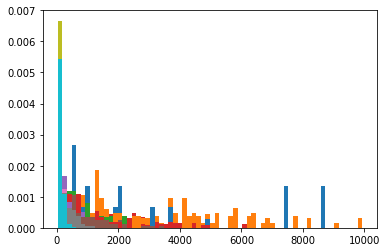

In [43]:
mean = pd.DataFrame()
alldata = pd.DataFrame()
sim_duration_distributions = pd.DataFrame()
for cond in distances.condition.unique():
    subsample_every = 1
    distances_selected = (
        distances[distances.condition == cond].iloc[::subsample_every].copy()
    )
    distances_selected.frame = distances_selected.frame.values / subsample_every
    distances_selected.condition = distances_selected.uniqueid
    (
        durations,
        second_passage_times,
        fraction_time,
        conditions,
        data,
    ) = calculate_duration_second_passage_time(
        distances_selected, resolution=30, model=results[cond], gt=True
    )
    tmp = pd.DataFrame(
        durations.groupby("cell_line").mean()["contact_duration"]
    ).reset_index()
    tmp["second_passage_time"] = (
        second_passage_times.groupby("cell_line").mean()["second_passage_time"].values
    )
    tmp["condition"] = cond
    mean = pd.concat([mean, tmp])
    alldata = pd.concat([data, alldata])

    for ctcf, sub in durations.groupby("cell_line"):
        hist = plt.hist(sub.contact_duration, bins=bins, density=True)
        tmp = pd.DataFrame(hist[0])
        tmp.columns = ["contact_duration"]
        tmp["condition"] = cond
        tmp["ctcf"] = ctcf
        sim_duration_distributions = pd.concat([sim_duration_distributions, tmp])


sim_duration_distributions["ctcf"] = [
    x.replace("ctcf", "")
    for x in sim_duration_distributions.ctcf.str.split(".", expand=True)[0]
]
mean[["speed", "loading", "unloading"]] = mean["condition"].str.extract(
    r"([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True
)
mean["ctcf"] = mean["cell_line"]

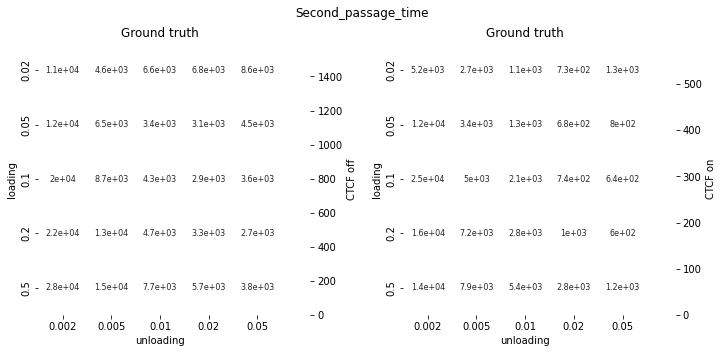

In [44]:
pdf = PdfPages(f"/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/simulated_data/{dataset_name}_2states_HMM_neighbor_{nneighbor}_gt_heatmaps.pdf")

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","white","white"])
# ctcf_off = 420
ctcf_off = 798.361204
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off*0, vcenter=ctcf_off, vmax=ctcf_off*2)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    mean[mean.ctcf=="ctcfoff.rad21on"].pivot("loading", "unloading", "second_passage_time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
)
ax[0].set_title(f"Ground truth")

# ctcf_on = 150
ctcf_on = 294.606742
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on*0, vcenter=ctcf_on, vmax=ctcf_on*2)
sns.heatmap(
    mean[mean.ctcf=="ctcfon.rad21on"].pivot("loading", "unloading", "second_passage_time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
)
ax[1].set_title(f"Ground truth")
plt.suptitle("Second_passage_time")
plt.show()
pdf.savefig(fig)

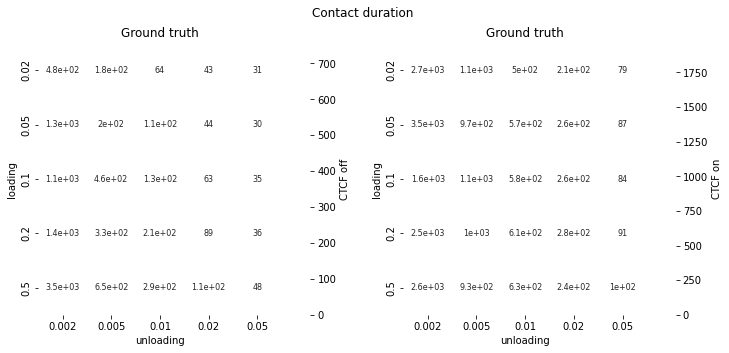

In [45]:
# ctcf_off = 270
ctcf_off = 378.529412
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off*0, vcenter=ctcf_off, vmax=ctcf_off*2)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    mean[mean.ctcf=="ctcfoff.rad21on"].pivot("loading", "unloading", "contact_duration"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
)
ax[0].set_title(f"Ground truth")

# ctcf_on = 480
ctcf_on = 981.293706
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on*0, vcenter=ctcf_on, vmax=ctcf_on*2)
sns.heatmap(
    mean[mean.ctcf=="ctcfon.rad21on"].pivot("loading", "unloading", "contact_duration"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
)
ax[1].set_title(f"Ground truth")
plt.suptitle("Contact duration")
plt.show()
pdf.savefig(fig)

posx and posy should be finite values
posx and posy should be finite values


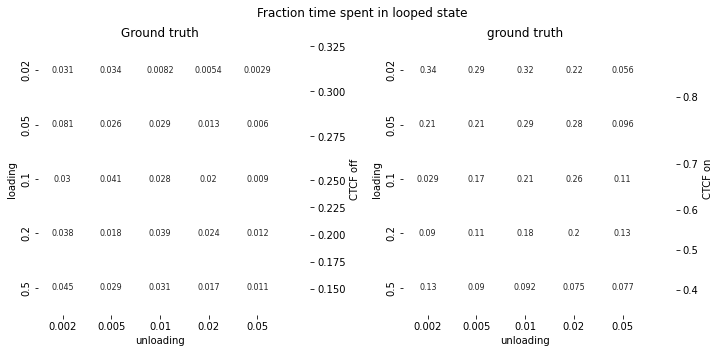

In [46]:
conditions = np.unique(
    [
        x[:-2].replace("ctcfon.", "").replace("ctcfoff.", "")
        for x in alldata.condition.unique()
    ]
)
# time_spent = pd.DataFrame([0.677557,
#         0.251439,])
# time_spent["ctcf"] = ["on", "off"]
# time_spent["type"] = "exp"
time_spent = pd.DataFrame()

for cond in conditions:
    realistic_subset_on = alldata[
        ["ctcfon." + cond in x for x in alldata.condition]
    ].copy()
    realistic_subset_off = alldata[
        ["ctcfoff." + cond in x for x in alldata.condition]
    ].copy()
    
    time = pd.DataFrame(
    [
        1 - realistic_subset_on.bond.mean(),
        1 - realistic_subset_off.bond.mean(),
    ],
    columns=["time"],
    )

    time["ctcf"] = ["on", "off"]
    time["type"] = cond
    time_spent = pd.concat([time_spent, time])

time_spent[["speed", "loading", "unloading"]] = time_spent["type"].str.extract(
    r"([\d+]*)\.([\d]\.[\d+]*)\.([\d]\.[\d+]*)", expand=True
)

ctcf_off = 0.251439
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off*0.5, vcenter=ctcf_off, vmax=ctcf_off*1.3)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    time_spent[time_spent.ctcf=="off"].pivot("loading", "unloading", "time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
)
ax[0].set_title(f"Ground truth")

ctcf_on = 0.677557
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on*0.5, vcenter=ctcf_on, vmax=ctcf_on*1.3)
sns.heatmap(
    time_spent[time_spent.ctcf=="on"].pivot("loading", "unloading", "time"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
)
ax[1].set_title(f"ground truth")
plt.suptitle("Fraction time spent in looped state")
plt.show()
pdf.savefig(fig)

posx and posy should be finite values
posx and posy should be finite values


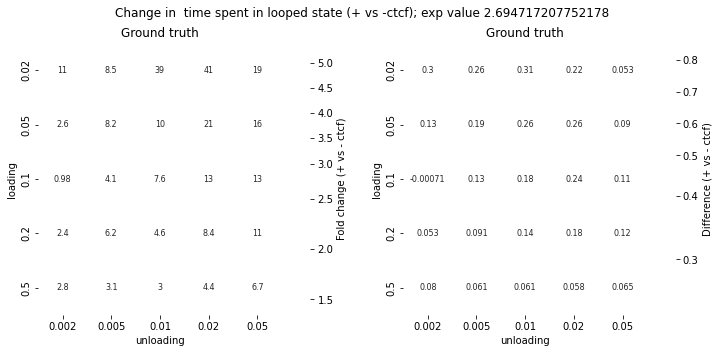

In [47]:
ctcfon = time_spent[time_spent.ctcf=="on"].copy()
ctcfoff = time_spent[time_spent.ctcf=="off"].copy()

ctcf = pd.merge(ctcfon, ctcfoff, on = ["loading", "unloading", "speed"])
ctcf["enrichment"] = ctcf["time_x"] / ctcf["time_y"]
ctcf["difference"] =  ctcf["time_x"] - ctcf["time_y"]

enrichment =  0.677557/ 0.251439
norm = mcolors.TwoSlopeNorm(vmin=enrichment*0.5, vcenter=enrichment, vmax=enrichment*2)
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sns.heatmap(
    ctcf.pivot("loading", "unloading", "enrichment"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "Fold change (+ vs - ctcf)"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[0]
   
)

ax[0].set_title(f"Ground truth")

difference = 0.677557- 0.251439
norm = mcolors.TwoSlopeNorm(vmin=difference*0.5, vcenter=difference, vmax=difference*2)
sns.heatmap(
    ctcf.pivot("loading", "unloading", "difference"),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "Difference (+ vs - ctcf)"},
    norm = norm, 
    annot_kws={"size":8},
    ax = ax[1]
   
)

ax[1].set_title(f"Ground truth")



plt.suptitle(f"Change in  time spent in looped state (+ vs -ctcf); exp value {enrichment}")
plt.show()
pdf.savefig(fig)

In [48]:
pdf.close()